# Assignment 2 Multi-label Classification

## Setup

### ***transformers***

#### Download *transformers*

In [2]:
!pip install -qq transformers # -qq is used to remove redundant information

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.5 MB/s eta 0:00:00


#### Necessary modules

In [3]:
from transformers import BertConfig, BertModel, BertForSequenceClassification, BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup # Optimizer and scheduler

#### Package version

In [ ]:
import transformers
print(f"Transformers version: {transformers.__version__}")

Transformers version: 4.29.1


### Necessary libraries

#### Importation

In [4]:
import os
import re
import math
import random
import zipfile
from io import StringIO, BytesIO
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam
from torch.nn.utils import clip_grad_norm_
import torch.hub as hub
from torch.hub import load_state_dict_from_url
import torchvision
from torchvision import transforms, datasets, models
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We are using {device}.")

We are using cuda.


#### Package version

In [ ]:
print("Software specifications:")
print(f"NumPy version: {np.__version__};")
print(f"Pandas version: {pd.__version__};")
print(f"Matplotlib version: {matplotlib.__version__};")
print(f"PyTorch version: {torch.__version__};")
print(f"PyTorch Vision version: {torchvision.__version__};")
print(f"Sci-kit learn version: {sklearn.__version__}.")

Software specifications:
NumPy version: 1.22.4;
Pandas version: 1.5.3;
Matplotlib version: 3.7.1;
PyTorch version: 2.0.0+cu118;
PyTorch Vision version: 0.15.1+cu118;
Sci-kit learn version: 1.2.2.


### Hardware information

#### CPU information

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.186
cache size	: 39424 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

#### GPU information

In [ ]:
!nvidia-smi

Fri May 12 02:47:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Dataset

#### Load images to the local environment

In [5]:
# Load the .zip file format of the images
# If you are unable to access the specific .zip file through this notebook, please download data.zip on your private device.
!cp "/content/drive/MyDrive/Assignment-2/data.zip" "/content/data.zip"
with zipfile.ZipFile("/content/data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data")
print("Images have been loaded and upzipped successfully.")

# Set the file path
google_drive_path = '/content/drive/MyDrive/Assignment-2/'# Might have to change this path on another machine
img_folder = '/content/data/data/'

Images have been loaded and upzipped successfully.


#### Dataset information

In [6]:
# Assign the dataset file names
train_set = 'train.csv'
test_set = 'test.csv'

# Load the train imageid, labels, and captions
with open(google_drive_path + train_set) as file:
  lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

# Load the test imageid, and captions
with open(google_drive_path + test_set) as file:
  lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

#### Information extraction

In [7]:
# Extract the corresponding information from the datasets
imgid_raw = df_train['ImageID'].to_numpy()
imgid_test = df_test['ImageID'].to_numpy()
caption_raw = df_train['Caption'].to_numpy()
caption_test = df_test['Caption'].to_numpy()
label_series = df_train['Labels'].apply(lambda x: list(map(int, x.split(" "))))
# Labels: one-hot encoding
binarizer = MultiLabelBinarizer()
label_binary = binarizer.fit_transform(label_series).tolist()

# Compute the number of labels
num_classes = len(label_binary[0])
# Compute the maximum length of captions
max_length = df_train['Caption'].str.len().max()
# Compute the minimum length of captions
min_length = df_train['Caption'].str.len().min()

# Make sure the ImageID and Captions randomly but in correct pairs
random_state = random.randint(0, 1e5)
imgid_train, imgid_valid, label_train, label_valid = train_test_split(imgid_raw, label_binary, 
                                                                      test_size=0.1, random_state=random_state)
caption_train, caption_valid, label_train, label_valid = train_test_split(caption_raw, label_binary, 
                                                                         test_size=0.1, random_state=random_state)
label_binary_tensor = torch.tensor(label_binary)
label_train_tensor = torch.tensor(label_train)
label_valid_tensor = torch.tensor(label_valid)

In [ ]:
# Overview of our datasets
print("This a multi-label classification task:")
print(f"There are {len(imgid_raw)} images in the training set, and {len(imgid_test)} images in the test set;")
print(f"There are {num_classes} different kinds of labels;")
print(f"The maximum length of captions is {max_length}, and the minimum langth of captions is {min_length}.")

This a multi-label classification task:
There are 29996 images in the training set, and 10000 images in the test set;
There are 18 different kinds of labels;
The maximum length of captions is 245, and the minimum langth of captions is 23.


In [8]:
# One-hot decoding
def decode(y_pred_encode, binarizer=binarizer):
  if isinstance(y_pred_encode, torch.Tensor):
    y_pred_numpy = y_pred_encode.numpy()
  elif isinstance(y_pred_encode, np.ndarray):
    y_pred_numpy = y_pred_encode
  
  if len(y_pred_numpy.shape) == 1:
    y_pred_numpy = y_pred_numpy.reshape(1, -1)
  y_pred_tuplst = binarizer.inverse_transform(y_pred_numpy)
  y_pred = []
  for tup in y_pred_tuplst:
    lst = list(tup)
    str_lst = list(map(str, lst))
    y_pred.append(" ".join(str_lst))
  y_pred = np.array(y_pred)
  if len(y_pred_encode.shape) == 1:
    return y_pred[0]
  else:
    return y_pred

#### Image-label Dataset

In [ ]:
# Customise ImageDataset
class ImageDataset(Dataset):
  def __init__(self, imgid_label, img_folder, transform=None):
    self.imgid_label = imgid_label
    self.img_folder = img_folder
    self.transform = transform

  def __getitem__(self, idx):
    imgid_ = self.imgid_label[idx][0]
    label_ = self.imgid_label[idx][1]
    img_path = os.path.join(self.img_folder, imgid_)
    img = Image.open(img_path).convert("RGB")
    if self.transform:
      img = self.transform(img)
    return img, label_

  def __len__(self):
    return len(self.imgid_label)

In [9]:
# Define a normalisation transformation, including Resize and Padding
class ResizeLongEdgeAndPad(object):
  def __init__(self, size, padding_mode='constant', fill=0):
    self.size = size
    self.padding_mode = padding_mode
    self.fill = fill

  def __call__(self, img):
    w, h = img.size
    if h > w:
      new_h = self.size
      new_w = int(self.size * w / h)
    else:
      new_w = self.size
      new_h = int(self.size * h / w)

    img = img.resize((new_w, new_h), Image.BICUBIC)

    pad_w = self.size - new_w
    pad_h = self.size - new_h

    padding = (pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2)
    return ImageOps.expand(img, padding, fill=self.fill)

# Define the normalisation method for test set
normalise = transforms.Compose([
    ResizeLongEdgeAndPad(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
imgid_label_train = []
for i, j in zip(imgid_train, label_train_tensor):
  imgid_label_train.append((i, j))

imgid_label_valid = []
for i, j in zip(imgid_valid, label_valid_tensor):
  imgid_label_valid.append((i, j))

In [10]:
# Define the data augmentation techniques
augments = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.Resize(232),
    transforms.RandomResizedCrop((224, 224), scale=(0.1, 1), ratio=(0.7, 1.0/0.7)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
img_train = ImageDataset(imgid_label_train, img_folder, transform=augments)
img_valid = ImageDataset(imgid_label_valid, img_folder, transform=normalise)
img_train_eval = ImageDataset(imgid_label_train, img_folder, transform=normalise)

img_label_train = DataLoader(img_train, batch_size=100, shuffle=True, num_workers=2)
img_label_valid = DataLoader(img_valid, batch_size=100, shuffle=True, num_workers=2)

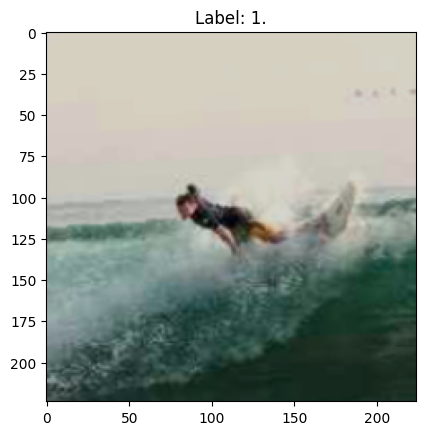

In [ ]:
# Check if the DataLoaders have been constructed successfully
def unnormalize(img_tensor):
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  for t, m, s in zip(img_tensor, mean, std):
    t.mul_(s).add_(m)
  return img_tensor

dataiter = iter(img_label_train)
images, labels = next(dataiter)
label_print = decode(labels[0])

def img_show(img, label):
  img_unnorm = unnormalize(img)
  img_numpy = img.numpy()
  plt.imshow(np.transpose(img_numpy, (1, 2, 0)))
  plt.title(f"Label: {label_print}.")
  plt.show()

img_show(images[0], label_print) # The image might be a bit strange due to data augmentation

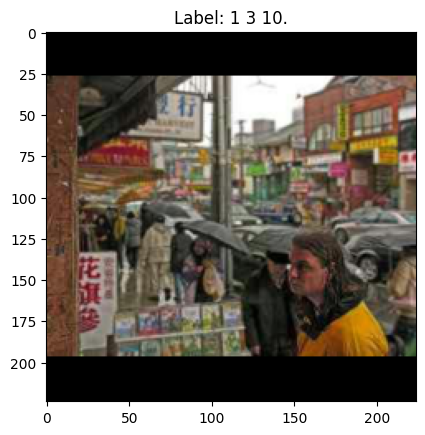

In [ ]:
dataiter = iter(img_label_valid)
images, labels = next(dataiter)
label_print = decode(labels[0])
img_show(images[0], label_print) # Black areas around the image due to padding

#### Text-label Dataset

In [ ]:
# Define a text data augmentation - random swap
def random_swap(words, n):
  words = words.copy()
  for _ in range(n):
    if len(words) < 2:
      break
    idx1, idx2 = random.sample(range(len(words)), 2)
    words[idx1], words[idx2] = words[idx2], words[idx1]
  return words

In [ ]:
# Customise TextDataset
class TextDataset(Dataset):
  def __init__(self, txt_label, tokenizer, max_length, random_swap_=False):
    self.txt_label = txt_label
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.random_swap_ = random_swap_

  def __len__(self):
    return len(self.txt_label)

  def __getitem__(self, idx):
    text = self.txt_label[idx][0]
    label = self.txt_label[idx][1]
    if self.random_swap_:
      words = text.split()
      words = random_swap(words, n=min_length)
      text = ' '.join(words)

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_length,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label': torch.tensor(label, dtype=torch.long)
    }

In [ ]:
txt_label_train = []
for i, j in zip(caption_train, label_train_tensor):
  txt_label_train.append((i, j))

txt_label_valid = []
for i, j in zip(caption_valid, label_valid_tensor):
  txt_label_valid.append((i, j))

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
txt_train = TextDataset(txt_label_train, tokenizer, max_length, random_swap_=True)
txt_valid = TextDataset(txt_label_valid, tokenizer, max_length)
txt_train_val = TextDataset(txt_label_train, tokenizer, max_length)

In [ ]:
n_samples = 10
txt_label_train = DataLoader(txt_train, batch_size=100, shuffle=True, num_workers=2)
dataiter = iter(txt_label_train)
data = next(dataiter)
txt, mask, labs = data['input_ids'], data['attention_mask'], data['label']
txt_10 = [tokenizer.decode(t.squeeze(), skip_special_tokens=True) for t in txt[:n_samples]]
mask_10 = [int(m.sum()) for m in mask[:n_samples]]
labs_10 = [decode(l) for l in labs[:n_samples]]
txt_samples = pd.DataFrame({
    'Text': txt_10,
    'Actual input length': mask_10,
    'Label': labs_10
})
txt_samples

,Text,Actual input length,Label
0,while down airborne a mountain. becomes skiing...,12,1
1,during races competition skiing downhill a ski...,10,1
2,to talking man on next a woman. a a phone,13,1
3,purple a a large hat. dog pimp wearing,12,18
4,is truck in parked of houses. front red a,12,8
5,street. busy double a decker bus a city down t...,13,1 2 3 6
6,in a hand umbrella has a women that her,11,1
7,across a surfers splashes water. as the paddle...,15,1
8,player bat ready to at a a game baseball getting,12,1
9,game front of room. and scooter a in of a a pi...,18,2 4


#### Multimodal-label Dataset

In [11]:
class MultimodalDataset(Dataset):
  def __init__(self, imgid_txt_label, img_folder, tokenizer, max_length, transform=None, random_swap_=False):
    self.imgid_txt_label = imgid_txt_label
    self.img_folder = img_folder
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.transform = transform
    self.random_swap_ = random_swap_

  def __len__(self):
    return len(self.imgid_txt_label)

  def __getitem__(self, idx):
    imgid_ = self.imgid_txt_label[idx][0]
    text = self.imgid_txt_label[idx][1]
    label = self.imgid_txt_label[idx][2]
    # Image operations
    img_path = os.path.join(self.img_folder, imgid_)
    img = Image.open(img_path).convert("RGB")
    if self.transform:
      img = self.transform(img)
    # Text operations
    if self.random_swap_:
      words = text.split()
      words = random_swap(words, n=5)
      text = ' '.join(words)

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_length,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    txt_dict = {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label': torch.tensor(label, dtype=torch.long)
    }
    return img, txt_dict

In [12]:
imgid_txt_label_train = []
for i, j, k in zip(imgid_train, caption_train, label_train_tensor):
  imgid_txt_label_train.append((i, j, k))

imgid_txt_label_valid = []
for i, j, k in zip(imgid_valid, caption_valid, label_valid_tensor):
  imgid_txt_label_valid.append((i, j, k))

imgid_txt_label_entire = []
for i, j, k in zip(imgid_raw, caption_raw, label_binary_tensor):
  imgid_txt_label_entire.append((i, j, k))

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mul_train = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, augments, random_swap_=True)
mul_valid = MultimodalDataset(imgid_txt_label_valid, img_folder, tokenizer, max_length, normalise)
mul_train_eval = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, normalise)

### Evaluation method

In [13]:
def f1_score_(y_pred, y_true, threshold=0.5):
  y_pred = torch.sigmoid(y_pred)
  y_pred = (y_pred.detach().cpu().numpy() >= threshold).astype(int)
  y_true = y_true.detach().cpu().numpy()
  return f1_score(y_true, y_pred, average='micro')

In [14]:
def model_size(model):
  buffer = BytesIO()
  torch.save(model.state_dict(), buffer, _use_new_zipfile_serialization=True)
  size = buffer.tell() / (1024*1024)
  buffer.close()
  return size

## Model Implementation

### Image Classifier

#### Training function

In [ ]:
def img_clf_train(model, train_loader, valid_loader, optimizer, criterion, epochs=20, clip_value=1.0, early_stop_threshold=10):
  '''Training epochs, which can track some metrics for visualisation'''
  loss_list = []
  f1_list = []
  valid_loss_list = [np.inf] # Start with a high validation loss
  valid_f1_list = []
  early_stop_counter = 0
  model.train()

  for ep in tqdm(range(epochs)):
    ep_loss = 0.0
    ep_f1 = 0.0
    for step, (x, y) in enumerate(train_loader):
      x = x.float().to(device)
      y = y.float().to(device) 
      optimizer.zero_grad()
      p = model(x)
      loss = criterion(p, y)
      f1 = f1_score_(p.detach().cpu(), y.detach().cpu())
      ep_loss += loss.item()
      ep_f1 += f1
      loss.backward()
      clip_grad_norm_(model.parameters(), clip_value)
      optimizer.step()
    loss_list.append(ep_loss/(step+1))
    f1_list.append(ep_f1/(step+1))

    model.eval()
    valid_loss = 0.0
    for x, y in valid_loader:
      x = x.float().to(device)
      y = y.float().to(device)
      p = model(x)
      loss = criterion(p, y)
      f1 = f1_score_(p.detach().cpu(), y.detach().cpu())
      valid_loss += loss.item()
      valid_f1_list.append(f1)

    if valid_loss/len(valid_loader) < valid_loss_list[-1]:
      early_stop_counter = 0
    else:
      early_stop_counter += 1

    valid_loss_list.append(valid_loss/len(valid_loader))
    model.train()

    if early_stop_counter >= early_stop_threshold:
      print("\nModel training finished due to early stopping.")
      break

  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  axs[0].plot(loss_list, color='red', label='Training Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  axs[0].set_title('Loss during Training')
  axs[0].legend(loc='best')
  
  axs[1].plot(f1_list, color=(1.0, 0.5, 0.0), label='Training F1 Score')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('F1 Score')
  axs[1].set_title('F1 Score during Training')
  axs[1].legend(loc='best')
  plt.show()

#### Evaluation function

In [ ]:
def img_model_f1_score_(model, data_loader, threshold=0.5):
  model.eval()
  all_y_true = []
  all_y_pred = []

  with torch.no_grad():
    for x, y_true in data_loader:
      if torch.cuda.is_available():
        x = x.to('cuda')
      y_pred = model(x)
      y_pred = y_pred.to('cpu')
      y_true = y_true.to('cpu')
      all_y_pred.append(y_pred)
      all_y_true.append(y_true)
  all_y_pred = torch.cat(all_y_pred, dim=0)
  all_y_true = torch.cat(all_y_true, dim=0)
  return f1_score_(all_y_pred, all_y_true, threshold)

#### ResNet

In [ ]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_channels, out_channels, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    
    self.shortcut = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels)
      )
  
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, in_channels, out_channels, stride=1):
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
    
    self.shortcut = nn.Sequential()
    if stride != 1 or in_channels != out_channels*self.expansion:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels*self.expansion, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels*self.expansion)
      )
  
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out
    
class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=num_classes):
    super(ResNet, self).__init__()
    self.in_channels = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, out_channels, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_channels, out_channels, stride))
      self.in_channels = out_channels * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, out.size()[2:])
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

##### ResNet-18

In [ ]:
# Define ResNet-18
def ResNet18(num_classes=1000):
  return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

resnet18 = ResNet18(num_classes)
resnet18_url = "https://download.pytorch.org/models/resnet18-f37072fd.pth"
resnet18_state_dict = load_state_dict_from_url(resnet18_url)
resnet18_state_dict_ = {k: v for k, v in resnet18_state_dict.items() if not k.startswith('fc')}
resnet18_state_dict__ = {k.replace("downsample", "shortcut").replace("fc", "linear"): v for k, v in resnet18_state_dict_.items()}
resnet18.load_state_dict(resnet18_state_dict__, strict=False)
init.kaiming_normal_(resnet18.linear.weight, mode='fan_out', nonlinearity='relu')
init.constant_(resnet18.linear.bias, 0)

# Train the fully-connected layer only
for param in resnet18.parameters():
    param.requires_grad = False
for param in resnet18.linear.parameters():
    param.requires_grad = True

100%|██████████| 20/20 [1:06:34<00:00, 199.75s/it]


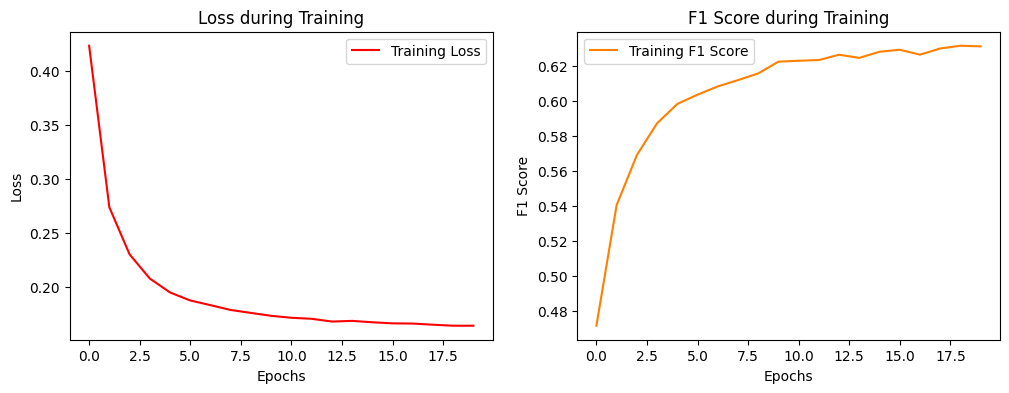

In [ ]:
# Train ResNet-18
resnet18.to(device)
train_loader = DataLoader(img_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(img_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 20
optimizer = Adam(resnet18.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
img_clf_train(resnet18, train_loader, valid_loader, optimizer, criterion, epochs)

In [ ]:
# Evaluate ResNet-18
train_loader = DataLoader(img_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(img_valid, batch_size=100, shuffle=False, num_workers=2)

model = resnet18
size = model_size(model)
f1_train = img_model_f1_score_(model, train_loader)
f1_valid = img_model_f1_score_(model, valid_loader)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 42.74MB;
Model F1 score on the training set: 0.6830;
Model F1 score on the validation set: 0.6795.


100%|██████████| 20/20 [55:34<00:00, 166.73s/it]


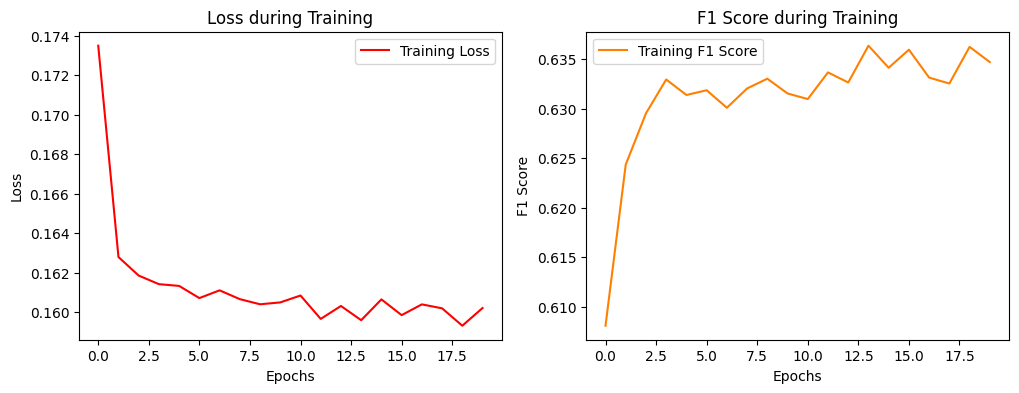

In [ ]:
# Another way to deploy ResNet-18
resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, num_classes)

for param in resnet18.parameters():
  param.requires_grad = False
for param in resnet18.fc.parameters():
  param.requires_grad = True

resnet18.to(device)
train_loader = DataLoader(img_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(img_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 20
optimizer = Adam(resnet18.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
img_clf_train(resnet18, train_loader, valid_loader, optimizer, criterion, epochs)

In [ ]:
train_loader = DataLoader(img_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(img_valid, batch_size=100, shuffle=False, num_workers=2)

model = resnet18
size = model_size(model)
f1_train = img_model_f1_score_(model, train_loader)
f1_valid = img_model_f1_score_(model, valid_loader)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 42.74MB;
Model F1 score on the training set: 0.6712;
Model F1 score on the validation set: 0.6612.


##### ResNet-34

In [ ]:
def ResNet34(num_classes=1000):
  return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

resnet34 = ResNet34(num_classes=num_classes)
resnet34_url = "https://download.pytorch.org/models/resnet34-b627a593.pth"
resnet34_state_dict = load_state_dict_from_url(resnet34_url)
resnet34_state_dict_ = {k: v for k, v in resnet34_state_dict.items() if not k.startswith('fc')}
resnet34_state_dict__ = {k.replace("downsample", "shortcut").replace("fc", "linear"): v for k, v in resnet34_state_dict_.items()}
resnet34.load_state_dict(resnet34_state_dict__, strict=False)
init.kaiming_normal_(resnet34.linear.weight, mode='fan_out', nonlinearity='relu')
init.constant_(resnet34.linear.bias, 0)

# Train the fully-connected layer only
for param in resnet34.parameters():
    param.requires_grad = False
for param in resnet34.linear.parameters():
    param.requires_grad = True

100%|██████████| 20/20 [52:39<00:00, 157.99s/it]


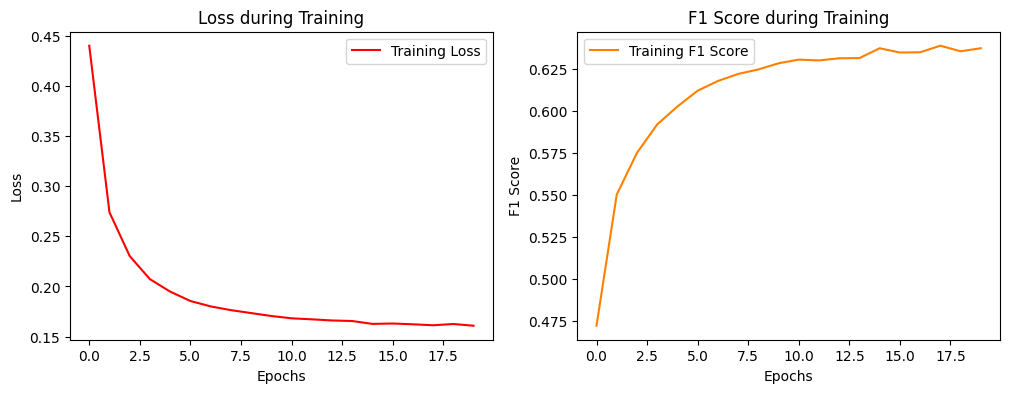

In [ ]:
# Train ResNet-34
resnet34.to(device)
train_loader = DataLoader(img_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(img_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 20
optimizer = Adam(resnet34.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
img_clf_train(resnet34, train_loader, valid_loader, optimizer, criterion, epochs)

In [ ]:
# Evaluate ResNet-34
train_loader = DataLoader(img_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(img_valid, batch_size=100, shuffle=False, num_workers=2)

model = resnet34
size = model_size(model)
f1_train = img_model_f1_score_(model, train_loader)
f1_valid = img_model_f1_score_(model, valid_loader)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 81.36MB;
Model F1 score on the training set: 0.6406;
Model F1 score on the validation set: 0.6304.


##### ResNet-50

20 Epochs

In [ ]:
# Define ResNet-50
def ResNet50(num_classes=1000):
  return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

resnet50 = ResNet50(num_classes=num_classes)
resnet50_url = "https://download.pytorch.org/models/resnet50-0676ba61.pth"
resnet50_state_dict = load_state_dict_from_url(resnet50_url)
resnet50_state_dict_ = {k: v for k, v in resnet50_state_dict.items() if not k.startswith('fc')}
resnet50_state_dict__ = {k.replace("downsample", "shortcut").replace("fc", "linear"): v for k, v in resnet50_state_dict_.items()}
resnet50.load_state_dict(resnet50_state_dict__, strict=False)
init.kaiming_normal_(resnet50.linear.weight, mode='fan_out', nonlinearity='relu')
init.constant_(resnet50.linear.bias, 0)

# Train the fully-connected layer only
for param in resnet50.parameters():
    param.requires_grad = False
for param in resnet50.linear.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


100%|██████████| 20/20 [58:37<00:00, 175.89s/it]


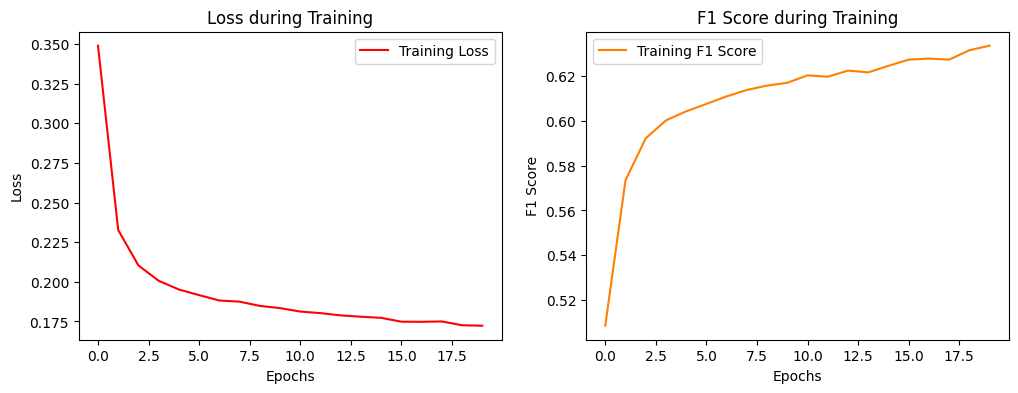

In [ ]:
# Train ResNet-50
resnet50.to(device)
train_loader = DataLoader(img_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(img_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 20
optimizer = Adam(resnet50.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
img_clf_train(resnet50, train_loader, valid_loader, optimizer, criterion, epochs)

In [ ]:
# Evaluate ResNet-50
train_loader = DataLoader(img_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(img_valid, batch_size=100, shuffle=False, num_workers=2)

model = resnet50
size = model_size(model)
f1_train = img_model_f1_score_(model, train_loader)
f1_valid = img_model_f1_score_(model, valid_loader)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 90.12MB;
Model F1 score on the training set: 0.7090;
Model F1 score on the validation set: 0.7063.


50 epochs

In [ ]:
# Define ResNet-50
def ResNet50(num_classes=1000):
  return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

resnet50 = ResNet50(num_classes=num_classes)
resnet50_url = "https://download.pytorch.org/models/resnet50-0676ba61.pth"
resnet50_state_dict = load_state_dict_from_url(resnet50_url)
resnet50_state_dict_ = {k: v for k, v in resnet50_state_dict.items() if not k.startswith('fc')}
resnet50_state_dict__ = {k.replace("downsample", "shortcut").replace("fc", "linear"): v for k, v in resnet50_state_dict_.items()}
resnet50.load_state_dict(resnet50_state_dict__, strict=False)
init.kaiming_normal_(resnet50.linear.weight, mode='fan_out', nonlinearity='relu')
# Evaluate ResNet-50
train_loader = DataLoader(img_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(img_valid, batch_size=100, shuffle=False, num_workers=2)

model = resnet50
size = model_size(model)
f1_train = img_model_f1_score_(model, train_loader)
f1_valid = img_model_f1_score_(model, valid_loader)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")
# Train the fully-connected layer only
for param in resnet50.parameters():
    param.requires_grad = False
for param in resnet50.linear.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 397MB/s]


100%|██████████| 50/50 [2:16:11<00:00, 163.43s/it]


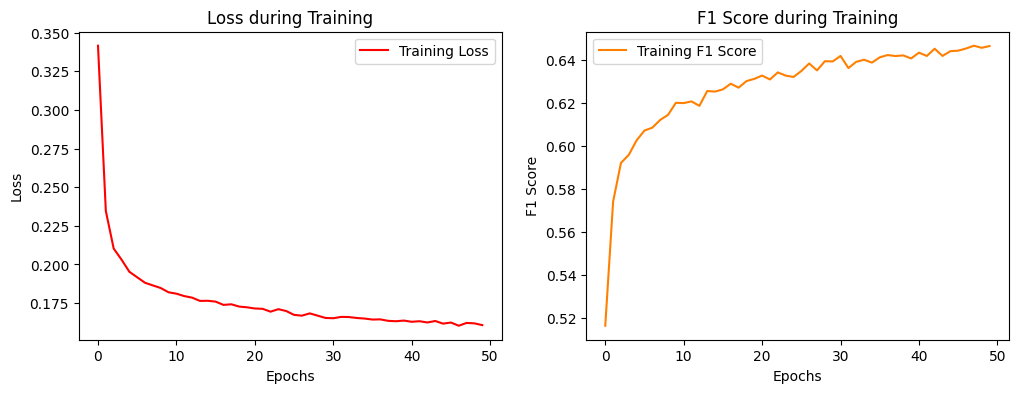

In [ ]:
# Train ResNet-50
resnet50.to(device)
train_loader = DataLoader(img_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(img_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 50
optimizer = Adam(resnet50.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
img_clf_train(resnet50, train_loader, valid_loader, optimizer, criterion, epochs)

In [ ]:
# Evaluate ResNet-50
train_loader = DataLoader(img_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(img_valid, batch_size=100, shuffle=False, num_workers=2)

model = resnet50
size = model_size(model)
f1_train = img_model_f1_score_(model, train_loader)
f1_valid = img_model_f1_score_(model, valid_loader)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 90.12MB;
Model F1 score on the training set: 0.7283;
Model F1 score on the validation set: 0.7260.


In [ ]:
torch.save(resnet50.state_dict(), google_drive_path + "resnet50.pth")

#### DenseNet

In [ ]:
densenet201 = models.densenet201(pretrained=True)
num_ftrs = densenet201.classifier.in_features
densenet201.classifier = nn.Linear(num_ftrs, num_classes)

for param in densenet201.parameters():
  param.requires_grad = False
for param in densenet201.classifier.parameters():
  param.requires_grad = True

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:03<00:00, 26.7MB/s]


100%|██████████| 50/50 [2:29:39<00:00, 179.58s/it]


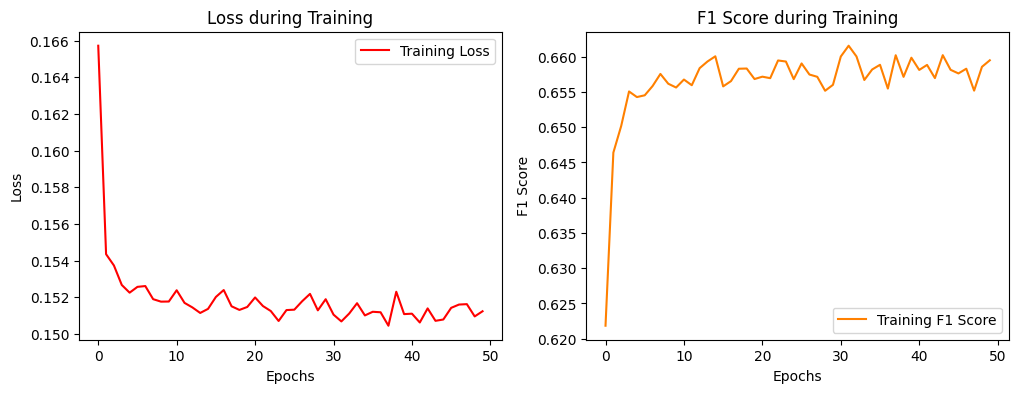

In [ ]:
densenet201.to(device)
train_loader = DataLoader(img_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(img_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 50
optimizer = Adam(densenet201.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
img_clf_train(densenet201, train_loader, valid_loader, optimizer, criterion, epochs)

In [ ]:
train_loader = DataLoader(img_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(img_valid, batch_size=100, shuffle=False, num_workers=2)

model = densenet201
size = model_size(model)
f1_train = img_model_f1_score_(model, train_loader)
f1_valid = img_model_f1_score_(model, valid_loader)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 70.45MB;
Model F1 score on the training set: 0.6728;
Model F1 score on the validation set: 0.6594.


In [ ]:
torch.save(densenet201.state_dict(), google_drive_path + "densenet201.pth")

### Text Classifier

#### Training function

In [ ]:
def txt_clf_train(model, train_loader, valid_loader, optimizer, criterion, scheduler, epochs=20, clip_value=1.0, early_stop_threshold=10):
  '''Training epochs, which can track some metrics for visualisation'''
  loss_list = []
  f1_list = []
  valid_loss_list = [np.inf] # Start with a high validation loss
  valid_f1_list = []
  early_stop_counter = 0
  model.train()

  for ep in tqdm(range(epochs)):
    ep_loss = 0.0
    ep_f1 = 0.0
    for step, batch in enumerate(train_loader):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].float().to(device)

      optimizer.zero_grad()
      output = model(input_ids, attention_mask=attention_mask)
      logits = output.logits
      loss = criterion(logits, labels)
      f1 = f1_score_(logits, labels.long())
      ep_loss += loss.item()
      ep_f1 += f1
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
      optimizer.step()
      scheduler.step()
    loss_list.append(ep_loss/(step+1))
    f1_list.append(ep_f1/(step+1))

    model.eval()
    valid_loss = 0.0
    valid_f1 = 0.0
    for batch in valid_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].float().to(device)
      output = model(input_ids, attention_mask=attention_mask)
      logits = output.logits
      loss = criterion(logits, labels)
      f1 = f1_score_(logits, labels.long())
      valid_loss += loss.item()
      valid_f1 += f1

    valid_loss_list.append(valid_loss/len(valid_loader))
    valid_f1_list.append(valid_f1/len(valid_loader))
    model.train()

    if valid_loss_list[-1] >= valid_loss_list[-2]:
      early_stop_counter += 1
    else:
      early_stop_counter = 0

    if early_stop_counter >= early_stop_threshold:
      print("\nModel training finished due to early stopping.")
      break

  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  axs[0].plot(loss_list, color='red', label='Training Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  axs[0].set_title('Loss during Training')
  axs[0].legend(loc='best')
  
  axs[1].plot(f1_list, color=(1.0, 0.5, 0.0), label='Training F1 Score')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('F1 Score')
  axs[1].set_title('F1 Score during Training')
  axs[1].legend(loc='best')
  plt.show()

#### Evaluation function

In [ ]:
def txt_model_f1_score_(model, data_loader, threshold=0.5):
  model.eval()
  all_y_true = []
  all_y_pred = []

  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      output = model(input_ids, attention_mask=attention_mask)
      logits = output.logits
      all_y_pred.append(logits)
      all_y_true.append(labels)

  all_y_pred = torch.cat(all_y_pred, dim=0)
  all_y_true = torch.cat(all_y_true, dim=0)

  return f1_score_(all_y_pred.cpu(), all_y_true.cpu(), threshold)

#### TinyBert

In [ ]:
config = BertConfig.from_pretrained("huawei-noah/TinyBERT_General_4L_312D", output_hidden_states=False, output_attentions=False)
tinybert = BertForSequenceClassification.from_pretrained("huawei-noah/TinyBERT_General_4L_312D", config=config)
tinybert.classifier = nn.Linear(config.hidden_size, num_classes)
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

for param in tinybert.parameters():
  param.requires_grad = False
for param in tinybert.classifier.parameters():
  param.requires_grad = True

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertForSequenceClassification: ['fit_denses.3.weight', 'cls.predictions.transform.dense.weight', 'fit_denses.0.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'fit_denses.1.weight', 'fit_denses.2.bias', 'fit_denses.4.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'fit_denses.3.bias', 'fit_denses.2.weight', 'fit_denses.4.bias', 'fit_denses.1.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'fit_denses.0.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a

100%|██████████| 50/50 [44:48<00:00, 53.76s/it]


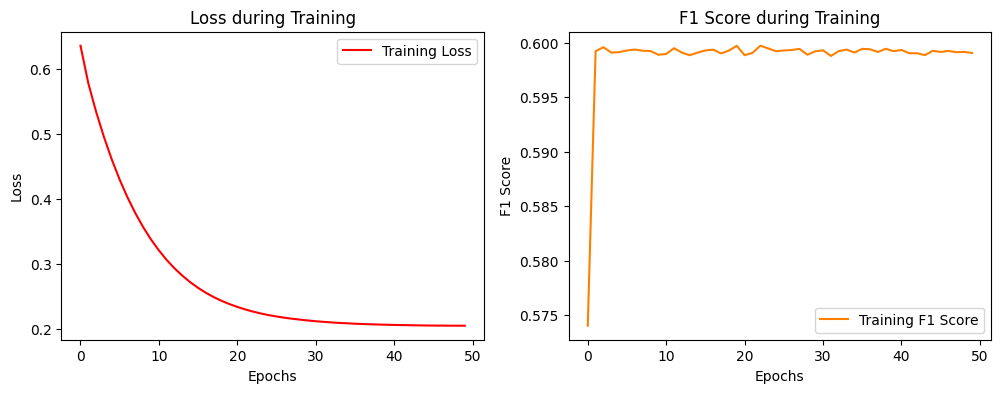

In [ ]:
tinybert.to(device)
txt_train = TextDataset(txt_label_train, tokenizer, max_length, random_swap_=True)
txt_valid = TextDataset(txt_label_valid, tokenizer, max_length)
txt_train_val = TextDataset(txt_label_train, tokenizer, max_length)
train_loader = DataLoader(txt_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(txt_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 50
optimizer = AdamW(tinybert.parameters(), lr=1e-5, correct_bias=False)
criterion = nn.BCEWithLogitsLoss()
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
txt_clf_train(tinybert, train_loader, valid_loader, optimizer, criterion, scheduler, epochs)

In [ ]:
train_loader = DataLoader(txt_train_val, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(txt_valid, batch_size=100, shuffle=False, num_workers=2)

model = tinybert
size = model_size(model)
f1_train = txt_model_f1_score_(model, train_loader, threshold=0.5)
f1_valid = txt_model_f1_score_(model, valid_loader, threshold=0.5)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 54.79MB;
Model F1 score on the training set: 0.5955;
Model F1 score on the validation set: 0.5975.


In [ ]:
torch.save(tinybert.state_dict(), google_drive_path + "tinybert.pth")

#### Bert-tiny

In [ ]:
bert_tiny = BertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=num_classes)
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')

for param in bert_tiny.parameters():
  param.requires_grad = False
for param in bert_tiny.classifier.parameters():
  param.requires_grad = True

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

100%|██████████| 50/50 [14:24<00:00, 17.30s/it]


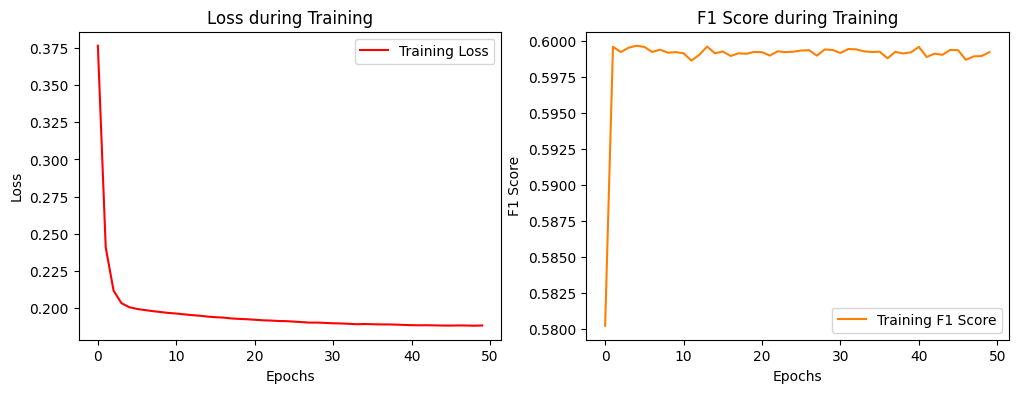

In [ ]:
bert_tiny.to(device)
txt_train = TextDataset(txt_label_train, tokenizer, max_length, random_swap_=True)
txt_valid = TextDataset(txt_label_valid, tokenizer, max_length)
txt_train_val = TextDataset(txt_label_train, tokenizer, max_length)
train_loader = DataLoader(txt_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(txt_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 50
optimizer = AdamW(bert_tiny.parameters(), lr=1e-5, correct_bias=False)
criterion = nn.BCEWithLogitsLoss()
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
txt_clf_train(bert_tiny, train_loader, valid_loader, optimizer, criterion, scheduler, epochs)

In [ ]:
train_loader = DataLoader(txt_train_val, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(txt_valid, batch_size=100, shuffle=False, num_workers=2)

model = bert_tiny
size = model_size(model)
f1_train = txt_model_f1_score_(model, train_loader, threshold=0.635)
f1_valid = txt_model_f1_score_(model, valid_loader, threshold=0.635)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 16.76MB;
Model F1 score on the training set: 0.5960;
Model F1 score on the validation set: 0.5989.


In [ ]:
torch.save(bert_tiny.state_dict(), google_drive_path + "bert_tiny.pth")

### Multimodal Classifier

#### Training function

In [15]:
def mul_clf_train(model, train_loader, valid_loader, optimizer, criterion, scheduler, epochs=20, clip_value=1.0, early_stop_threshold=10):
  '''Training epochs, which can track some metrics for visualisation'''
  loss_list = []
  f1_list = []
  valid_loss_list = [np.inf] # Start with a high validation loss
  valid_f1_list = []
  early_stop_counter = 0
  model.train()

  for ep in tqdm(range(epochs)):
    ep_loss = 0.0
    ep_f1 = 0.0
    for step, (img, txt) in enumerate(train_loader):
      img = img.float().to(device)
      input_ids = txt['input_ids'].to(device)
      attention_mask = txt['attention_mask'].to(device)
      labels = txt['label'].float().to(device)

      optimizer.zero_grad()
      logits = model(img, input_ids, attention_mask)
      loss = criterion(logits, labels)
      f1 = f1_score_(logits.detach().cpu(), labels.long())
      ep_loss += loss.item()
      ep_f1 += f1
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
      optimizer.step()
      scheduler.step()
    loss_list.append(ep_loss/(step+1))
    f1_list.append(ep_f1/(step+1))

    model.eval()
    valid_loss = 0.0
    valid_f1 = 0.0
    for img, txt in valid_loader:
      img = img.float().to(device)
      input_ids = txt['input_ids'].to(device)
      attention_mask = txt['attention_mask'].to(device)
      labels = txt['label'].float().to(device)
      logits = model(img, input_ids, attention_mask)
      loss = criterion(logits, labels)
      f1 = f1_score_(logits.detach().cpu(), labels.long())
      valid_loss += loss.item()
      valid_f1 += f1

    valid_loss_list.append(valid_loss/len(valid_loader))
    valid_f1_list.append(valid_f1/len(valid_loader))
    model.train()

    if valid_loss_list[-1] >= valid_loss_list[-2]:
      early_stop_counter += 1
    else:
      early_stop_counter = 0

    if early_stop_counter >= early_stop_threshold:
      print("\nModel training finished due to early stopping.")
      break

  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  axs[0].plot(loss_list, color='red', label='Training Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  axs[0].set_title('Loss during Training')
  axs[0].legend(loc='best')
  
  axs[1].plot(f1_list, color=(1.0, 0.5, 0.0), label='Training F1 Score')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('F1 Score')
  axs[1].set_title('F1 Score during Training')
  axs[1].legend(loc='best')
  plt.show()

#### Evaluation function

In [16]:
def mul_model_f1_score_(model, data_loader, threshold=0.5):
  model.eval()
  all_y_true = []
  all_y_pred = []

  with torch.no_grad():
    for batch in data_loader:
      images, txt = batch
      images = images.to(device)
      input_ids = txt['input_ids'].to(device)
      attention_mask = txt['attention_mask'].to(device)
      labels = txt['label'].to(device)

      logits = model(images, input_ids, attention_mask)
      all_y_pred.append(logits)
      all_y_true.append(labels)

  all_y_pred = torch.cat(all_y_pred, dim=0)
  all_y_true = torch.cat(all_y_true, dim=0)

  return f1_score_(all_y_pred.cpu(), all_y_true.cpu(), threshold)

#### DenseNet & TinyBert

##### DensityBert
DensityBert stands for DenseNet-121 and TinyBert.

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    super(SelfAttention, self).__init__()
    self.query = nn.Linear(input_dim, input_dim)
    self.key = nn.Linear(input_dim, input_dim)
    self.value = nn.Linear(input_dim, input_dim)
    
  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    return output

class DensityBert(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet121(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze the image feature extractor
    for param in self.img_featrs.parameters():
      param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    # Freeze the text feature extractor
    for param in self.txt_featrs.parameters():
      param.requires_grad = False
    # Define the attention layer
    self.image_attention = SelfAttention(self.img_featrs.features.norm5.num_features)
    self.text_attention = SelfAttention(self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    
    image_attention_outputs = self.image_attention(image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features))
    text_attention_outputs = self.text_attention(text_features)
    # Average pooling
    image_attention_weights = image_attention_outputs.mean(dim=1)
    text_attention_weights = text_attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(image_attention_weights)
    text_features = self.text_features_fc(text_attention_weights)
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['fit_denses.3.weight', 'cls.predictions.transform.dense.weight', 'fit_denses.0.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'fit_denses.1.weight', 'fit_denses.2.bias', 'fit_denses.4.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'fit_denses.3.bias', 'fit_denses.2.weight', 'fit_denses.4.bias', 'fit_denses.1.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'fit_denses.0.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

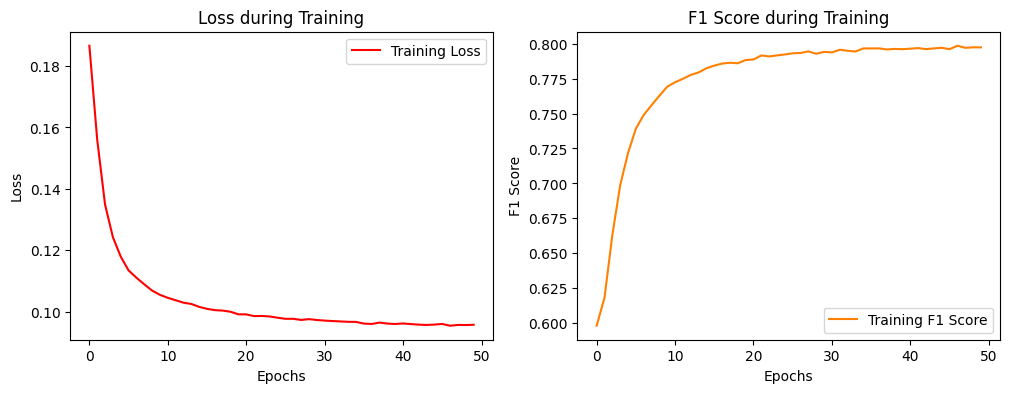

In [ ]:
densitybert = DensityBert(num_classes).to(device)
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_train = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, augments, random_swap_=True)
mul_valid = MultimodalDataset(imgid_txt_label_valid, img_folder, tokenizer, max_length, normalise)
mul_train_eval = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, normalise)
train_loader = DataLoader(mul_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 50
optimizer = AdamW(densitybert.parameters(), lr=1e-5, correct_bias=False)
criterion = nn.BCEWithLogitsLoss()
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
mul_clf_train(densitybert, train_loader, valid_loader, optimizer, criterion, scheduler, epochs)

In [ ]:
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)

model = densitybert
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.35)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.35)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 97.71MB;
Model F1 score on the training set: 0.8173;
Model F1 score on the validation set: 0.8173.


In [ ]:
torch.save(densitybert.state_dict(), google_drive_path + "densitybert.pth")

##### MoDensityBert
MoDensityBert stands for Modified DensityBert, which is added by Layer Normalisation.

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    super(SelfAttention, self).__init__()
    self.query = nn.Linear(input_dim, input_dim)
    self.key = nn.Linear(input_dim, input_dim)
    self.value = nn.Linear(input_dim, input_dim)
    # Add a Layer Normalisation layer
    self.layer_norm = nn.LayerNorm(input_dim)
    # Add a learnable weight
    self.learnable_weight = nn.Parameter(torch.ones((input_dim,)))
    
  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    # Apply the learnable weight
    output = output * self.learnable_weight
    # Apply Layer Normalisation to the output
    output = self.layer_norm(output)
    return output

class MoDensityBert(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet121(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze the image feature extractor
    for param in self.img_featrs.parameters():
      param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    # Freeze the text feature extractor
    for param in self.txt_featrs.parameters():
      param.requires_grad = False
    # Define the attention layer
    self.image_attention = SelfAttention(self.img_featrs.features.norm5.num_features)
    self.text_attention = SelfAttention(self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    
    image_attention_outputs = self.image_attention(image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features))
    text_attention_outputs = self.text_attention(text_features)
    # Average pooling
    image_attention_weights = image_attention_outputs.mean(dim=1)
    text_attention_weights = text_attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(image_attention_weights)
    text_features = self.text_features_fc(text_attention_weights)
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['fit_denses.2.weight', 'fit_denses.4.bias', 'cls.seq_relationship.bias', 'fit_denses.0.weight', 'fit_denses.1.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'fit_denses.1.weight', 'cls.predictions.transform.LayerNorm.bias', 'fit_denses.4.weight', 'cls.predictions.transform.LayerNorm.weight', 'fit_denses.3.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'fit_denses.2.bias', 'cls.predictions.transform.dense.weight', 'fit_denses.0.bias', 'fit_denses.3.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

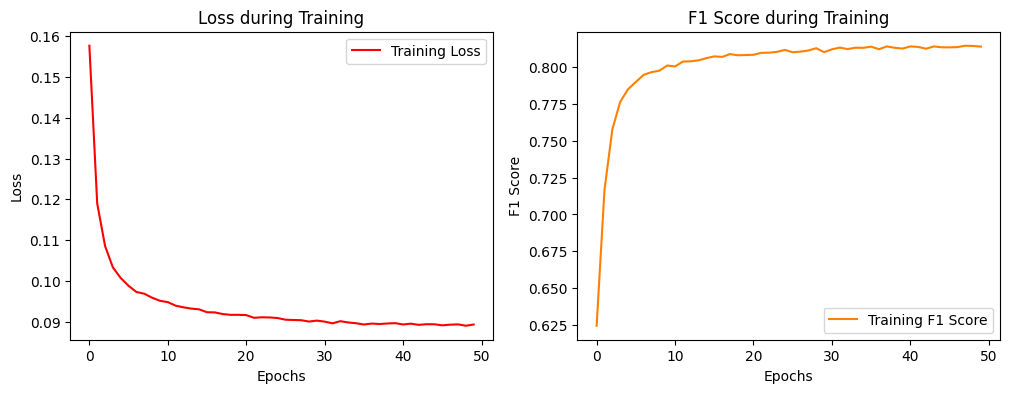

In [ ]:
modensitybert = MoDensityBert(num_classes).to(device)
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_train = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, augments, random_swap_=True)
mul_valid = MultimodalDataset(imgid_txt_label_valid, img_folder, tokenizer, max_length, normalise)
mul_train_eval = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, normalise)
train_loader = DataLoader(mul_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 50
optimizer = AdamW(modensitybert.parameters(), lr=1e-5, correct_bias=False)
criterion = nn.BCEWithLogitsLoss()
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
mul_clf_train(modensitybert, train_loader, valid_loader, optimizer, criterion, scheduler, epochs)

In [ ]:
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)

model = modensitybert
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.38)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.38)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 97.72MB;
Model F1 score on the training set: 0.8266;
Model F1 score on the validation set: 0.8179.


In [ ]:
torch.save(modensitybert.state_dict(), google_drive_path + "modensitybert.pth")

##### WarmDBert
WarmDBert stands for DensityBert whose part of parameters are unfrozen.

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    super(SelfAttention, self).__init__()
    self.query = nn.Linear(input_dim, input_dim)
    self.key = nn.Linear(input_dim, input_dim)
    self.value = nn.Linear(input_dim, input_dim)
    # Add a Layer Normalisation layer
    self.layer_norm = nn.LayerNorm(input_dim)
    # Add a learnable weight
    self.learnable_weight = nn.Parameter(torch.ones((input_dim,)))
    
  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    # Apply the learnable weight
    output = output * self.learnable_weight
    # Apply Layer Normalisation to the output
    output = self.layer_norm(output)
    return output

class WarmDBert(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet121(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze part layers of the image feature extractor
    for name, param in self.img_featrs.named_parameters():
      if 'denseblock4' not in name:
        param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    # Freeze part layers of the text feature extractor
    for name, param in self.txt_featrs.named_parameters():
      if 'encoder.layer.3' not in name:
        param.requires_grad = False
    # Define the attention layer
    self.image_attention = SelfAttention(self.img_featrs.features.norm5.num_features)
    self.text_attention = SelfAttention(self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    
    image_attention_outputs = self.image_attention(image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features))
    text_attention_outputs = self.text_attention(text_features)
    # Average pooling
    image_attention_weights = image_attention_outputs.mean(dim=1)
    text_attention_weights = text_attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(image_attention_weights)
    text_features = self.text_features_fc(text_attention_weights)
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['fit_denses.2.weight', 'fit_denses.4.bias', 'cls.seq_relationship.bias', 'fit_denses.0.weight', 'fit_denses.1.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'fit_denses.1.weight', 'cls.predictions.transform.LayerNorm.bias', 'fit_denses.4.weight', 'cls.predictions.transform.LayerNorm.weight', 'fit_denses.3.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'fit_denses.2.bias', 'cls.predictions.transform.dense.weight', 'fit_denses.0.bias', 'fit_denses.3.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

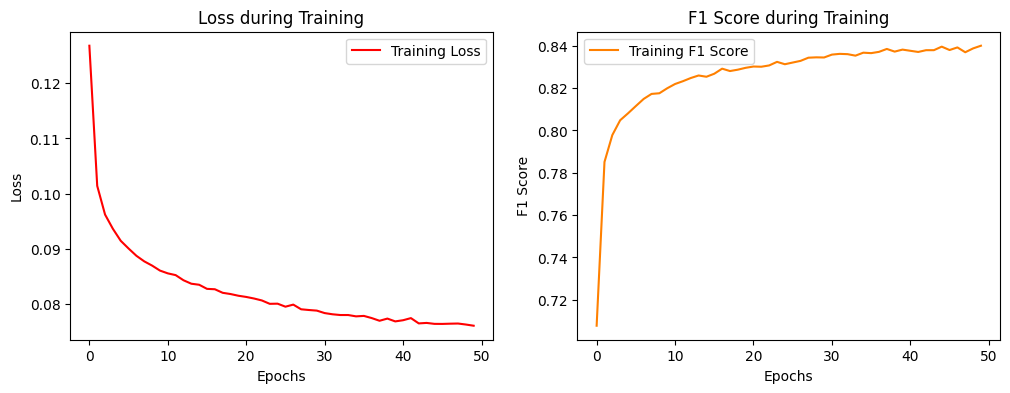

In [ ]:
warmdbert = WarmDBert(num_classes).to(device)
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_train = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, augments, random_swap_=True)
mul_valid = MultimodalDataset(imgid_txt_label_valid, img_folder, tokenizer, max_length, normalise)
mul_train_eval = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, normalise)
train_loader = DataLoader(mul_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 50
optimizer = AdamW(warmdbert.parameters(), lr=1e-5, correct_bias=False)
criterion = nn.BCEWithLogitsLoss()
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
mul_clf_train(warmdbert, train_loader, valid_loader, optimizer, criterion, scheduler, epochs)

In [ ]:
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)

model = warmdbert
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.38)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.38)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 97.72MB;
Model F1 score on the training set: 0.8505;
Model F1 score on the validation set: 0.8310.


In [ ]:
torch.save(warmdbert.state_dict(), google_drive_path + "warmdbert.pth")

##### WarmerDBert

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    super(SelfAttention, self).__init__()
    self.query = nn.Linear(input_dim, input_dim)
    self.key = nn.Linear(input_dim, input_dim)
    self.value = nn.Linear(input_dim, input_dim)
    # Add a Layer Normalisation layer
    self.layer_norm = nn.LayerNorm(input_dim)
    # Add a learnable weight
    self.learnable_weight = nn.Parameter(torch.ones((input_dim,)))
    
  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    # Apply the learnable weight
    output = output * self.learnable_weight
    # Apply Layer Normalisation to the output
    output = self.layer_norm(output)
    return output

class WarmerDBert(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet121(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze part layers of the image feature extractor
    for name, param in self.img_featrs.named_parameters():
      if 'denseblock3' not in name:
        param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    # Freeze part layers of the text feature extractor
    for name, param in self.txt_featrs.named_parameters():
      if 'encoder.layer.2' not in name:
        param.requires_grad = False
    # Define the attention layer
    self.image_attention = SelfAttention(self.img_featrs.features.norm5.num_features)
    self.text_attention = SelfAttention(self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    
    image_attention_outputs = self.image_attention(image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features))
    text_attention_outputs = self.text_attention(text_features)
    # Average pooling
    image_attention_weights = image_attention_outputs.mean(dim=1)
    text_attention_weights = text_attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(image_attention_weights)
    text_features = self.text_features_fc(text_attention_weights)
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'fit_denses.2.bias', 'cls.predictions.decoder.weight', 'fit_denses.1.weight', 'cls.predictions.transform.LayerNorm.bias', 'fit_denses.0.bias', 'cls.predictions.transform.dense.weight', 'fit_denses.4.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'fit_denses.4.bias', 'cls.seq_relationship.bias', 'fit_denses.3.weight', 'fit_denses.3.bias', 'fit_denses.1.bias', 'fit_denses.2.weight', 'cls.predictions.bias', 'fit_denses.0.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

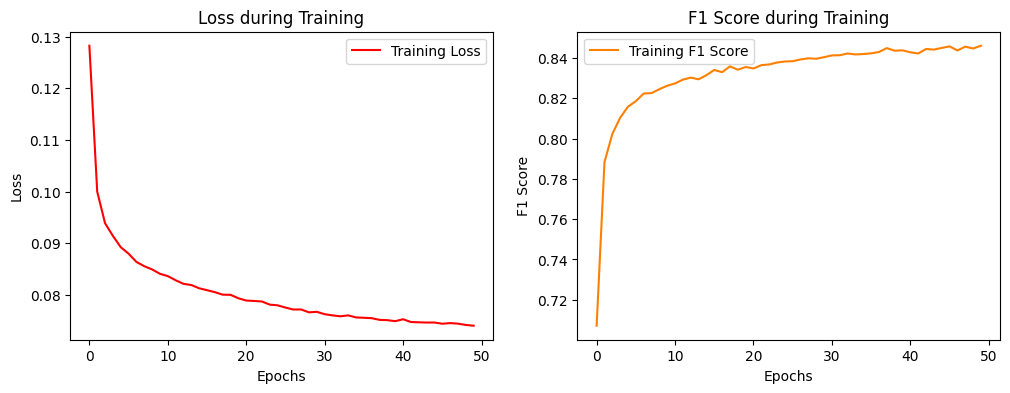

In [ ]:
warmerdbert = WarmerDBert(num_classes).to(device)
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_train = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, augments, random_swap_=True)
mul_valid = MultimodalDataset(imgid_txt_label_valid, img_folder, tokenizer, max_length, normalise)
mul_train_eval = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, normalise)
train_loader = DataLoader(mul_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 50
optimizer = AdamW(warmerdbert.parameters(), lr=1e-5, correct_bias=False)
criterion = nn.BCEWithLogitsLoss()
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
mul_clf_train(warmerdbert, train_loader, valid_loader, optimizer, criterion, scheduler, epochs)

In [ ]:
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)

model = warmerdbert
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.39)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.39)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 97.72MB;
Model F1 score on the training set: 0.8567;
Model F1 score on the validation set: 0.8345.


In [ ]:
torch.save(warmerdbert.state_dict(), google_drive_path + "warmerdbert.pth")

##### WarmerDBert_

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    super(SelfAttention, self).__init__()
    self.query = nn.Linear(input_dim, input_dim)
    self.key = nn.Linear(input_dim, input_dim)
    self.value = nn.Linear(input_dim, input_dim)
    # Add a Layer Normalisation layer
    self.layer_norm = nn.LayerNorm(input_dim)
    # Add a learnable weight
    self.learnable_weight = nn.Parameter(torch.ones((input_dim,)))
    
  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    # Apply the learnable weight
    output = output * self.learnable_weight
    # Apply Layer Normalisation to the output
    output = self.layer_norm(output)
    return output

class WarmerDBert_(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet121(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze part layers of the image feature extractor
    img_flag = True
    for name, param in self.img_featrs.named_parameters():
      if 'denseblock3' in name:
        img_flag = False
      param.requires_grad = not img_flag
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    # Freeze part layers of the text feature extractor
    txt_flag = True
    for name, param in self.txt_featrs.named_parameters():
      if 'encoder.layer.2' in name:
        txt_flag = False
      param.requires_grad = not txt_flag
    # Define the attention layer
    self.image_attention = SelfAttention(self.img_featrs.features.norm5.num_features)
    self.text_attention = SelfAttention(self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    
    image_attention_outputs = self.image_attention(image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features))
    text_attention_outputs = self.text_attention(text_features)
    # Average pooling
    image_attention_weights = image_attention_outputs.mean(dim=1)
    text_attention_weights = text_attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(image_attention_weights)
    text_features = self.text_features_fc(text_attention_weights)
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['fit_denses.3.bias', 'cls.predictions.bias', 'fit_denses.0.weight', 'cls.seq_relationship.bias', 'fit_denses.2.weight', 'fit_denses.3.weight', 'fit_denses.2.bias', 'fit_denses.4.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'fit_denses.4.weight', 'fit_denses.0.bias', 'cls.predictions.transform.dense.bias', 'fit_denses.1.weight', 'fit_denses.1.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

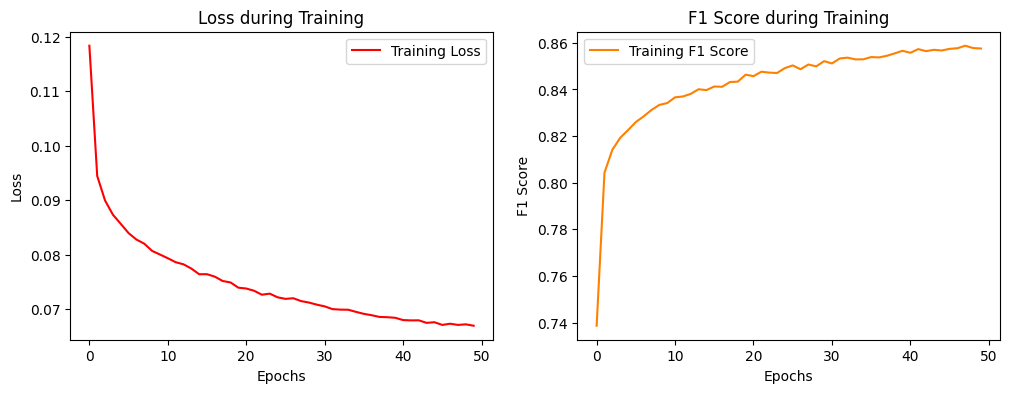

In [ ]:
warmerdbert_ = WarmerDBert_(num_classes).to(device)
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_train = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, augments, random_swap_=True)
mul_valid = MultimodalDataset(imgid_txt_label_valid, img_folder, tokenizer, max_length, normalise)
mul_train_eval = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, normalise)
train_loader = DataLoader(mul_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 50
optimizer = AdamW(warmerdbert_.parameters(), lr=1e-5, correct_bias=False)
criterion = nn.BCEWithLogitsLoss()
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
mul_clf_train(warmerdbert_, train_loader, valid_loader, optimizer, criterion, scheduler, epochs)

In [ ]:
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)

model = warmerdbert_
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.42)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.42)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 97.72MB;
Model F1 score on the training set: 0.8698;
Model F1 score on the validation set: 0.8485.


In [ ]:
torch.save(warmerdbert_.state_dict(), google_drive_path + "warmerdbert_.pth")

##### WWDBert

In [17]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    super(SelfAttention, self).__init__()
    self.query = nn.Linear(input_dim, input_dim)
    self.key = nn.Linear(input_dim, input_dim)
    self.value = nn.Linear(input_dim, input_dim)
    # Add a Layer Normalisation layer
    self.layer_norm = nn.LayerNorm(input_dim)
    # Add a learnable weight
    self.learnable_weight = nn.Parameter(torch.ones((input_dim,)))
    
  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    # Apply the learnable weight
    output = output * self.learnable_weight
    # Apply Layer Normalisation to the output
    output = self.layer_norm(output)
    return output

class WWDBert(nn.Module):
  def __init__(self, num_classes, dropout_rate=0.5):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet121(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze part layers of the image feature extractor
    for name, param in self.img_featrs.named_parameters():
      if 'denseblock3' not in name:
        param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    # Freeze part layers of the text feature extractor
    for name, param in self.txt_featrs.named_parameters():
      if 'encoder.layer.2' not in name:
        param.requires_grad = False
    # Define the attention layer
    self.image_attention = SelfAttention(self.img_featrs.features.norm5.num_features)
    self.text_attention = SelfAttention(self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 896)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 896)
    # Add Batch Normalization layers
    self.bn1 = nn.BatchNorm1d(896)
    self.bn2 = nn.BatchNorm1d(896)
    # Add Dropout layers
    self.dropout1 = nn.Dropout(dropout_rate)
    self.dropout2 = nn.Dropout(dropout_rate)
    self.dropout3 = nn.Dropout(dropout_rate)
    self.classifier = nn.Linear(896 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    
    image_attention_outputs = self.image_attention(image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features))
    text_attention_outputs = self.text_attention(text_features)
    # Average pooling
    image_attention_weights = image_attention_outputs.mean(dim=1)
    text_attention_weights = text_attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(image_attention_weights)
    text_features = self.text_features_fc(text_attention_weights)
    # Batch normalisation
    image_features = self.bn1(image_features)
    text_features = self.bn2(text_features)
    # Add activation function
    image_features = torch.relu(image_features)
    text_features = torch.relu(text_features)
    # Add Dropout layers
    image_features = self.dropout1(image_features)
    text_features = self.dropout2(text_features)
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['fit_denses.3.bias', 'cls.predictions.bias', 'fit_denses.0.weight', 'cls.seq_relationship.bias', 'fit_denses.2.weight', 'fit_denses.3.weight', 'fit_denses.2.bias', 'fit_denses.4.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'fit_denses.4.weight', 'fit_denses.0.bias', 'cls.predictions.transform.dense.bias', 'fit_denses.1.weight', 'fit_denses.1.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

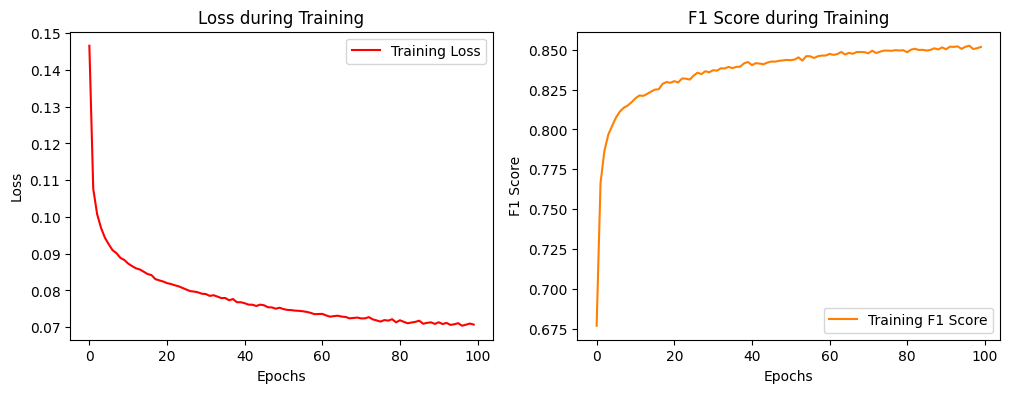

In [43]:
wwdbert = WWDBert(num_classes).to(device)
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_train = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, augments, random_swap_=True)
mul_valid = MultimodalDataset(imgid_txt_label_valid, img_folder, tokenizer, max_length, normalise)
mul_train_eval = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, normalise)
train_loader = DataLoader(mul_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 100
optimizer = AdamW(wwdbert.parameters(), lr=1e-5, correct_bias=False)
criterion = nn.BCEWithLogitsLoss()
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
mul_clf_train(wwdbert, train_loader, valid_loader, optimizer, criterion, scheduler, epochs)

In [54]:
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)

model = wwdbert
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.40)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.40)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model F1 score on the training set: 0.8700;
Model F1 score on the validation set: 0.8464.


In [45]:
torch.save(wwdbert.state_dict(), google_drive_path + "wwdbert.pth")

WWDBert on the entire dataset

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['fit_denses.3.bias', 'cls.predictions.bias', 'fit_denses.0.weight', 'cls.seq_relationship.bias', 'fit_denses.2.weight', 'fit_denses.3.weight', 'fit_denses.2.bias', 'fit_denses.4.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'fit_denses.4.weight', 'fit_denses.0.bias', 'cls.predictions.transform.dense.bias', 'fit_denses.1.weight', 'fit_denses.1.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

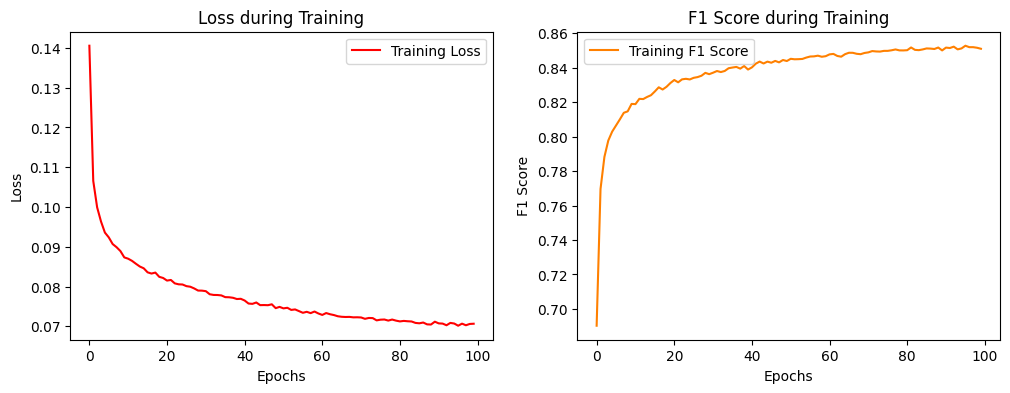

In [57]:
wwdbert_ = WWDBert(num_classes).to(device)
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_train = MultimodalDataset(imgid_txt_label_entire, img_folder, tokenizer, max_length, augments, random_swap_=True)
mul_valid = MultimodalDataset(imgid_txt_label_valid, img_folder, tokenizer, max_length, normalise)
mul_train_eval = MultimodalDataset(imgid_txt_label_entire, img_folder, tokenizer, max_length, normalise)
train_loader = DataLoader(mul_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 100
optimizer = AdamW(wwdbert_.parameters(), lr=1e-5, correct_bias=False)
criterion = nn.BCEWithLogitsLoss()
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
mul_clf_train(wwdbert_, train_loader, valid_loader, optimizer, criterion, scheduler, epochs)

In [33]:
mul_train_eval = MultimodalDataset(imgid_txt_label_entire, img_folder, tokenizer, max_length, normalise)
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)

model = wwdbert_
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.376)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f}.")

Model size: 99.77MB;
Model F1 score on the training set: 0.8682.


In [59]:
torch.save(wwdbert.state_dict(), google_drive_path + "wwdbert_.pth")

##### CDBert-Text
CDBert stands for DensityBert with Cross Attention mechanism.   
Text: Query.   
Image: Key & value.  

In [ ]:
class CrossAttention(nn.Module):
  def __init__(self, query_dim, key_dim):
    super(CrossAttention, self).__init__()
    self.query = nn.Linear(query_dim, key_dim)
    self.key = nn.Linear(key_dim, key_dim)
    self.value = nn.Linear(key_dim, key_dim)

  def forward(self, query, key):
    q = self.query(query)
    k = self.key(key)
    v = self.value(key)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    return output

class CDBert(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet121(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze the image feature extractor
    for param in self.img_featrs.parameters():
        param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    # Freeze the text feature extractor
    for param in self.txt_featrs.parameters():
        param.requires_grad = False
    # Define the attention layer
    self.attention = CrossAttention(self.txt_featrs.config.hidden_size, self.img_featrs.features.norm5.num_features)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    image_features = image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features)
    
    attention_outputs = self.attention(text_features, image_features)
    # Average pooling
    attention_weights = attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(attention_weights)
    text_features = self.text_features_fc(text_features.mean(dim=1))
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['fit_denses.2.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'fit_denses.4.weight', 'fit_denses.0.weight', 'fit_denses.2.bias', 'fit_denses.1.weight', 'fit_denses.3.bias', 'cls.seq_relationship.bias', 'fit_denses.1.bias', 'cls.seq_relationship.weight', 'fit_denses.0.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'fit_denses.3.weight', 'cls.predictions.transform.LayerNorm.bias', 'fit_denses.4.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

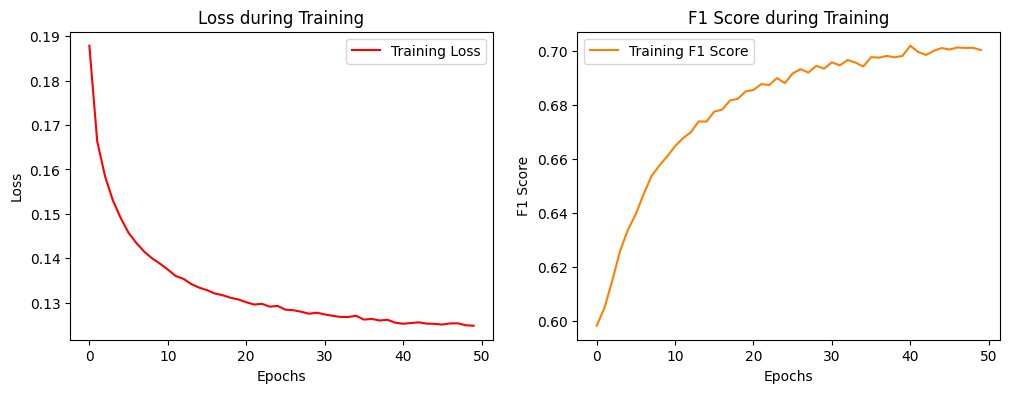

In [ ]:
cdbert = CDBert(num_classes).to(device)
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_train = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, augments, random_swap_=True)
mul_valid = MultimodalDataset(imgid_txt_label_valid, img_folder, tokenizer, max_length, normalise)
mul_train_eval = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, normalise)
train_loader = DataLoader(mul_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 50
optimizer = AdamW(cdbert.parameters(), lr=1e-5, correct_bias=False)
criterion = nn.BCEWithLogitsLoss()
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
mul_clf_train(cdbert, train_loader, valid_loader, optimizer, criterion, scheduler, epochs)

In [ ]:
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)

model = cdbert
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.29)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.29)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 93.81MB;
Model F1 score on the training set: 0.7599;
Model F1 score on the validation set: 0.7564.


In [ ]:
torch.save(cdbert.state_dict(), google_drive_path + "cdbert.pth")

##### CDBert-Image
CDBert stands for DensityBert with Cross Attention mechanism.   
Image: Query.   
Text: Key & value.

In [ ]:
class CrossAttention(nn.Module):
  def __init__(self, query_dim, key_dim):
    super(CrossAttention, self).__init__()
    self.query = nn.Linear(query_dim, query_dim)
    self.key = nn.Linear(key_dim, query_dim)
    self.value = nn.Linear(key_dim, query_dim)

  def forward(self, query, key):
    q = self.query(query)
    k = self.key(key)
    v = self.value(key)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    return output

class ImCDBert(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet121(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze the image feature extractor
    for param in self.img_featrs.parameters():
        param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    # Freeze the text feature extractor
    for param in self.txt_featrs.parameters():
        param.requires_grad = False
    # Define the attention layer
    self.attention = CrossAttention(self.img_featrs.features.norm5.num_features, self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    image_features = image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features)
    
    attention_outputs = self.attention(image_features, text_features)
    # Average pooling
    attention_weights = attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(attention_weights)
    text_features = self.text_features_fc(text_features.mean(dim=1))
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 264MB/s]


Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['fit_denses.2.weight', 'fit_denses.4.bias', 'cls.seq_relationship.bias', 'fit_denses.0.weight', 'fit_denses.1.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'fit_denses.1.weight', 'cls.predictions.transform.LayerNorm.bias', 'fit_denses.4.weight', 'cls.predictions.transform.LayerNorm.weight', 'fit_denses.3.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'fit_denses.2.bias', 'cls.predictions.transform.dense.weight', 'fit_denses.0.bias', 'fit_denses.3.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

100%|██████████| 50/50 [2:25:37<00:00, 174.75s/it]


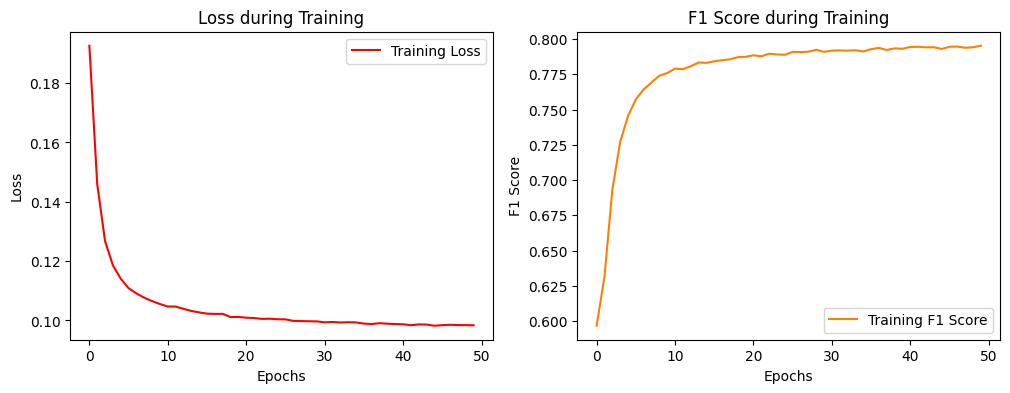

In [ ]:
imcdbert = ImCDBert(num_classes).to(device)
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_train = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, augments, random_swap_=True)
mul_valid = MultimodalDataset(imgid_txt_label_valid, img_folder, tokenizer, max_length, normalise)
mul_train_eval = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, normalise)
train_loader = DataLoader(mul_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 50
optimizer = AdamW(imcdbert.parameters(), lr=1e-5, correct_bias=False)
criterion = nn.BCEWithLogitsLoss()
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
mul_clf_train(imcdbert, train_loader, valid_loader, optimizer, criterion, scheduler, epochs)

In [ ]:
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)

model = imcdbert
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.461)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.461)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 91.02MB;
Model F1 score on the training set: 0.8026;
Model F1 score on the validation set: 0.7965.


In [ ]:
torch.save(imcdbert.state_dict(), google_drive_path + "imcdbert.pth")

#### Bert tiny & DenseNet

##### Bensity
Bensity stands for DenseNet-201 and Bert-Tiny.

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    super(SelfAttention, self).__init__()
    self.query = nn.Linear(input_dim, input_dim)
    self.key = nn.Linear(input_dim, input_dim)
    self.value = nn.Linear(input_dim, input_dim)

  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    return output

class Bensity(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet169(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze the image feature extractor
    for param in self.img_featrs.parameters():
      param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("prajjwal1/bert-tiny")
    # Freeze the text feature extractor
    for param in self.txt_featrs.parameters():
      param.requires_grad = False
    # Define the attention layer
    self.image_attention = SelfAttention(self.img_featrs.features.norm5.num_features)
    self.text_attention = SelfAttention(self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    
    image_attention_outputs = self.image_attention(image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features))
    text_attention_outputs = self.text_attention(text_features)
    # Average pooling
    image_attention_weights = image_attention_outputs.mean(dim=1)
    text_attention_weights = text_attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(image_attention_weights)
    text_features = self.text_features_fc(text_attention_weights)
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 50/50 [2:38:20<00:00, 190.01s/it]


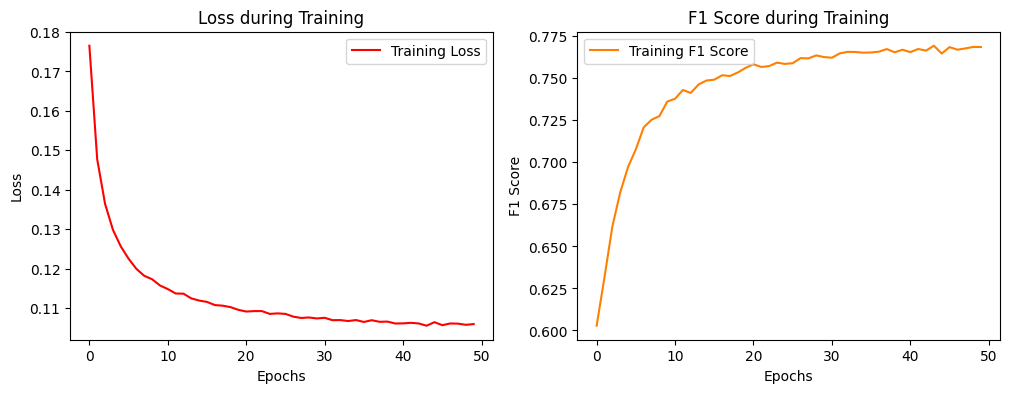

In [ ]:
bensity = Bensity(num_classes).to(device)
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")
mul_train = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, augments, random_swap_=True)
mul_valid = MultimodalDataset(imgid_txt_label_valid, img_folder, tokenizer, max_length, normalise)
mul_train_eval = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, normalise)
train_loader = DataLoader(mul_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 50
optimizer = AdamW(bensity.parameters(), lr=1e-5, correct_bias=False)
criterion = nn.BCEWithLogitsLoss()
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
mul_clf_train(bensity, train_loader, valid_loader, optimizer, criterion, scheduler, epochs)

In [ ]:
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)

model = bensity
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.33)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.33)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 100.83MB;
Model F1 score on the training set: 0.7980;
Model F1 score on the validation set: 0.7980.


In [ ]:
torch.save(bensity.state_dict(), google_drive_path + "bensity.pth")

##### Censity-Text
Censity stands for Bensity with Cross Attention mechanism.   
Text: Query.   
Image: Key & value.   

In [ ]:
class CrossAttention(nn.Module):
  def __init__(self, query_dim, key_dim):
    super(CrossAttention, self).__init__()
    self.query = nn.Linear(query_dim, key_dim)
    self.key = nn.Linear(key_dim, key_dim)
    self.value = nn.Linear(key_dim, key_dim)

  def forward(self, query, key):
    q = self.query(query)
    k = self.key(key)
    v = self.value(key)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    return output

class Censity(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet169(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze the image feature extractor
    for param in self.img_featrs.parameters():
      param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("prajjwal1/bert-tiny")
    # Freeze the text feature extractor
    for param in self.txt_featrs.parameters():
      param.requires_grad = False
    # Define the attention layer
    self.attention = CrossAttention(self.txt_featrs.config.hidden_size, self.img_featrs.features.norm5.num_features)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    image_features = image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features)
    # Cross attention
    attention_outputs = self.attention(text_features, image_features)
    # Average pooling
    attention_weights = attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(attention_weights)
    text_features = self.text_features_fc(text_features.mean(dim=1))
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████| 50/50 [2:32:54<00:00, 183.50s/it]


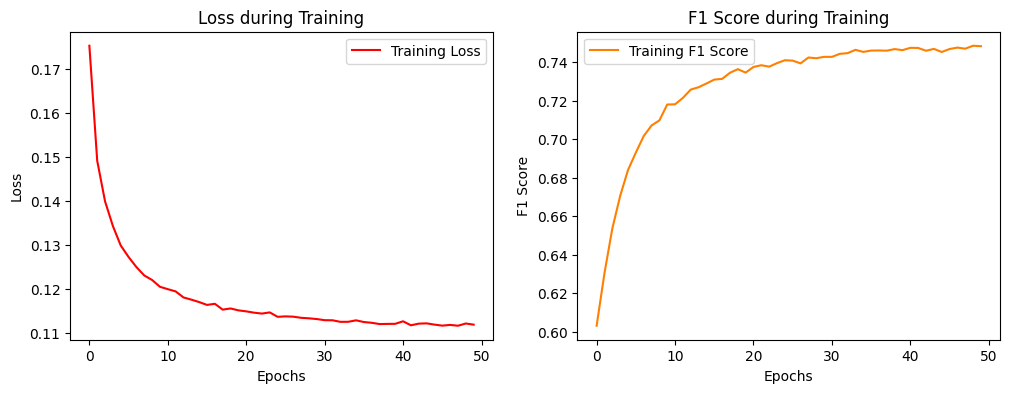

In [ ]:
censity = Censity(num_classes).to(device)
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")
mul_train = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, augments, random_swap_=True)
mul_valid = MultimodalDataset(imgid_txt_label_valid, img_folder, tokenizer, max_length, normalise)
mul_train_eval = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, normalise)
train_loader = DataLoader(mul_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 50
optimizer = AdamW(censity.parameters(), lr=1e-5, correct_bias=False)
criterion = nn.BCEWithLogitsLoss()
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
mul_clf_train(censity, train_loader, valid_loader, optimizer, criterion, scheduler, epochs)

In [ ]:
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)

model = censity
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.33)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.33)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 90.89MB;
Model F1 score on the training set: 0.7905;
Model F1 score on the validation set: 0.7901.


In [ ]:
torch.save(censity.state_dict(), google_drive_path + "censity.pth")

##### Censity-Image
Censity stands for Bensity with Cross Attention mechanism.   
Image: Query.   
Text: Key & value.

In [ ]:
class CrossAttention(nn.Module):
  def __init__(self, query_dim, key_dim):
    super(CrossAttention, self).__init__()
    self.query = nn.Linear(query_dim, query_dim)
    self.key = nn.Linear(key_dim, query_dim)
    self.value = nn.Linear(key_dim, query_dim)

  def forward(self, query, key):
    q = self.query(query)
    k = self.key(key)
    v = self.value(key)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    return output

class ImCensity(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet169(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze the image feature extractor
    for param in self.img_featrs.parameters():
      param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("prajjwal1/bert-tiny")
    # Freeze the text feature extractor
    for param in self.txt_featrs.parameters():
      param.requires_grad = False
    # Define the attention layer
    self.attention = CrossAttention(self.img_featrs.features.norm5.num_features, self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    image_features = image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features)
    
    attention_outputs = self.attention(image_features, text_features)
    # Average pooling
    attention_weights = attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(attention_weights)
    text_features = self.text_features_fc(text_features.mean(dim=1))
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 79.9MB/s]


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████| 50/50 [2:25:24<00:00, 174.49s/it]


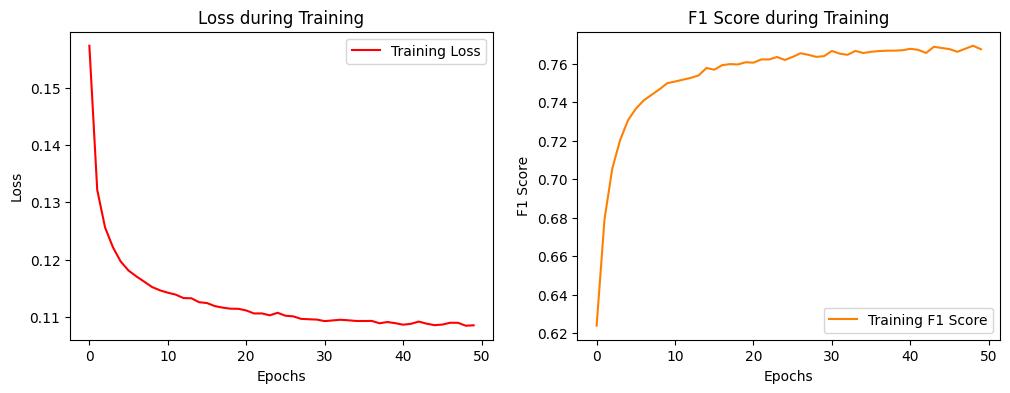

In [ ]:
imcensity = ImCensity(num_classes).to(device)
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")
mul_train = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, augments, random_swap_=True)
mul_valid = MultimodalDataset(imgid_txt_label_valid, img_folder, tokenizer, max_length, normalise)
mul_train_eval = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, normalise)
train_loader = DataLoader(mul_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 50
optimizer = AdamW(imcensity.parameters(), lr=1e-5, correct_bias=False)
criterion = nn.BCEWithLogitsLoss()
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
mul_clf_train(imcensity, train_loader, valid_loader, optimizer, criterion, scheduler, epochs)

In [ ]:
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)

model = imcensity
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.38)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.38)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 81.14MB;
Model F1 score on the training set: 0.7869;
Model F1 score on the validation set: 0.7801.


In [ ]:
torch.save(imcensity.state_dict(), google_drive_path + "imcensity.pth")

#### ResNet & Bert tiny - ResT
ResT stands for ResNet and Bert-tiny.

In [ ]:
class CrossAttention(nn.Module):
  def __init__(self, query_dim, key_dim, output_dim):
    super(CrossAttention, self).__init__()
    self.query = nn.Linear(query_dim, output_dim)
    self.key = nn.Linear(key_dim, output_dim)
    self.value = nn.Linear(key_dim, output_dim)
    # Add Layer Normalisation
    self.layer_norm = nn.LayerNorm(output_dim)

  def forward(self, query, key):
    q = self.query(query)
    k = self.key(key)
    v = self.value(key)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    # Apply Layer Normalisation to the output
    output = self.layer_norm(output)
    return output

class ResT(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.resnet34(pretrained=True)
    self.img_featrs.fc = nn.Identity()
    # Freeze the image feature extractor
    for param in self.img_featrs.parameters():
        param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("prajjwal1/bert-tiny")
    # Freeze the text feature extractor
    for param in self.txt_featrs.parameters():
        param.requires_grad = False
    # Define the attention layer
    self.attention = CrossAttention(512, self.txt_featrs.config.hidden_size, 512)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(512, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    image_features = image_features.view(image_features.size(0), -1)
    
    attention_outputs = self.attention(image_features, text_features)
    # Average pooling
    attention_weights = attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(attention_weights)
    text_features = self.text_features_fc(text_features.mean(dim=1))
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 50/50 [2:21:42<00:00, 170.06s/it]


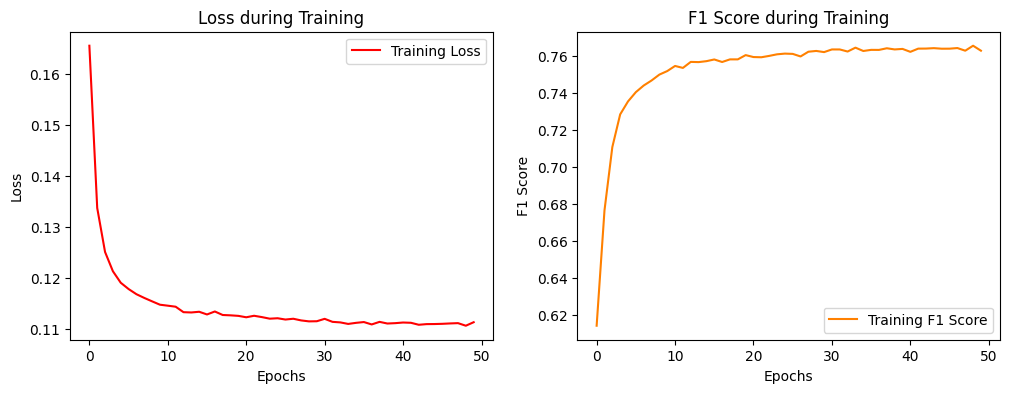

In [ ]:
rest = ResT(num_classes).to(device)
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")
mul_train = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, augments, random_swap_=True)
mul_valid = MultimodalDataset(imgid_txt_label_valid, img_folder, tokenizer, max_length, normalise)
mul_train_eval = MultimodalDataset(imgid_txt_label_train, img_folder, tokenizer, max_length, normalise)
train_loader = DataLoader(mul_train, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
epochs = 50
optimizer = AdamW(rest.parameters(), lr=1e-5, correct_bias=False)
criterion = nn.BCEWithLogitsLoss()
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
mul_clf_train(rest, train_loader, valid_loader, optimizer, criterion, scheduler, epochs)

In [ ]:
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)

model = rest
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.38)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.38)

print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

Model size: 100.92MB;
Model F1 score on the training set: 0.7836;
Model F1 score on the validation set: 0.7766.


In [ ]:
torch.save(rest.state_dict(), google_drive_path + "rest.pth")

## Predictions

### ResNet-50

In [ ]:
def ResNet50(num_classes=1000):
  return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

resnet50 = ResNet50(num_classes=num_classes)
resnet50.to(device).load_state_dict(torch.load(google_drive_path + "resnet50.pth", map_location=device))
train_loader = DataLoader(img_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(img_valid, batch_size=100, shuffle=False, num_workers=2)
model = resnet50
f1_train = img_model_f1_score_(model, train_loader, threshold=0.36)
f1_valid = img_model_f1_score_(model, valid_loader, threshold=0.36)
print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

imgid_label_test = [(imgid, 0) for imgid in imgid_test]
img_test = ImageDataset(imgid_label_test, img_folder, transform=normalise)
img_label_test = DataLoader(img_test, batch_size=100, shuffle=False, num_workers=2)
label_test = []
resnet50.eval()
with torch.no_grad():
  for imgs, labels in img_label_test:
    imgs = imgs.to(device)
    prediction = resnet50(imgs)
    predicted_prob = torch.sigmoid(prediction)
    predicted_labels = (predicted_prob > 0.36).cpu().numpy()
    label_test.append(predicted_labels)
label_test = np.concatenate(label_test).astype(int)
label_str = decode(label_test)
pred_dict = {'ImageID': imgid_test, 'Labels': label_str}
df = pd.DataFrame(pred_dict)
df.to_csv(google_drive_path + "jixu9182.csv", index=False)

Model size: 90.12MB;
Model F1 score on the training set: 0.7386;
Model F1 score on the validation set: 0.7370.


### DensityBert

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    super(SelfAttention, self).__init__()
    self.query = nn.Linear(input_dim, input_dim)
    self.key = nn.Linear(input_dim, input_dim)
    self.value = nn.Linear(input_dim, input_dim)

  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    return output

class DensityBert(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet121(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze the image feature extractor
    for param in self.img_featrs.parameters():
      param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    # Freeze the text feature extractor
    for param in self.txt_featrs.parameters():
      param.requires_grad = False
    # Define the attention layer
    self.image_attention = SelfAttention(self.img_featrs.features.norm5.num_features)
    self.text_attention = SelfAttention(self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    
    image_attention_outputs = self.image_attention(image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features))
    text_attention_outputs = self.text_attention(text_features)
    # Average pooling
    image_attention_weights = image_attention_outputs.mean(dim=1)
    text_attention_weights = text_attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(image_attention_weights)
    text_features = self.text_features_fc(text_attention_weights)
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

densitybert = DensityBert(num_classes).to(device)
densitybert.load_state_dict(torch.load(google_drive_path + "densitybert.pth", map_location=device))
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
model = densitybert
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.35)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.35)
print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")


imgid_txt_label_test = [(imgid, txt, 0) for imgid, txt in zip(imgid_test, caption_test)]
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_test = MultimodalDataset(imgid_txt_label_test, img_folder, tokenizer, max_length, normalise)
mul_label_test = DataLoader(mul_test, batch_size=100, shuffle=False, num_workers=2)
label_test = []
densitybert.eval()
with torch.no_grad():
  for img, txt in mul_label_test:
    img = img.to(device)
    input_ids = txt['input_ids'].to(device)
    attention_mask = txt['attention_mask'].to(device)
    labels = txt['label'].to(device)

    prediction = densitybert(img, input_ids, attention_mask)
    predicted_prob = torch.sigmoid(prediction)
    predicted_labels = (predicted_prob > 0.35).cpu().numpy()
    label_test.append(predicted_labels)
label_test = np.concatenate(label_test).astype(int)
label_str = decode(label_test)
pred_dict = {'ImageID': imgid_test, 'Labels': label_str}
df = pd.DataFrame(pred_dict)
df.to_csv(google_drive_path + "jixu9182.csv", index=False)

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['fit_denses.3.weight', 'cls.predictions.transform.dense.weight', 'fit_denses.0.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'fit_denses.1.weight', 'fit_denses.2.bias', 'fit_denses.4.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'fit_denses.3.bias', 'fit_denses.2.weight', 'fit_denses.4.bias', 'fit_denses.1.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'fit_denses.0.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

Model size: 97.71MB;
Model F1 score on the training set: 0.8173;
Model F1 score on the validation set: 0.8173.


### MoDensityBert

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    super(SelfAttention, self).__init__()
    self.query = nn.Linear(input_dim, input_dim)
    self.key = nn.Linear(input_dim, input_dim)
    self.value = nn.Linear(input_dim, input_dim)
    # Add a Layer Normalisation layer
    self.layer_norm = nn.LayerNorm(input_dim)
    # Add a learnable weight
    self.learnable_weight = nn.Parameter(torch.ones((input_dim,)))
    
  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    # Apply the learnable weight
    output = output * self.learnable_weight
    # Apply Layer Normalisation to the output
    output = self.layer_norm(output)
    return output

class MoDensityBert(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet121(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze the image feature extractor
    for param in self.img_featrs.parameters():
      param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    # Freeze the text feature extractor
    for param in self.txt_featrs.parameters():
      param.requires_grad = False
    # Define the attention layer
    self.image_attention = SelfAttention(self.img_featrs.features.norm5.num_features)
    self.text_attention = SelfAttention(self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    
    image_attention_outputs = self.image_attention(image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features))
    text_attention_outputs = self.text_attention(text_features)
    # Average pooling
    image_attention_weights = image_attention_outputs.mean(dim=1)
    text_attention_weights = text_attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(image_attention_weights)
    text_features = self.text_features_fc(text_attention_weights)
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

modensitybert = MoDensityBert(num_classes).to(device)
modensitybert.load_state_dict(torch.load(google_drive_path + "modensitybert.pth", map_location=device))
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
model = modensitybert
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.38)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.38)
print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

imgid_txt_label_test = [(imgid, txt, 0) for imgid, txt in zip(imgid_test, caption_test)]
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_test = MultimodalDataset(imgid_txt_label_test, img_folder, tokenizer, max_length, normalise)
mul_label_test = DataLoader(mul_test, batch_size=100, shuffle=False, num_workers=2)
label_test = []
modensitybert.eval()
with torch.no_grad():
  for img, txt in mul_label_test:
    img = img.to(device)
    input_ids = txt['input_ids'].to(device)
    attention_mask = txt['attention_mask'].to(device)
    labels = txt['label'].to(device)

    prediction = modensitybert(img, input_ids, attention_mask)
    predicted_prob = torch.sigmoid(prediction)
    predicted_labels = (predicted_prob > 0.38).cpu().numpy()
    label_test.append(predicted_labels)
label_test = np.concatenate(label_test).astype(int)
label_str = decode(label_test)
pred_dict = {'ImageID': imgid_test, 'Labels': label_str}
df = pd.DataFrame(pred_dict)
df.to_csv(google_drive_path + "jixu9182.csv", index=False)

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['fit_denses.2.weight', 'fit_denses.4.bias', 'cls.seq_relationship.bias', 'fit_denses.0.weight', 'fit_denses.1.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'fit_denses.1.weight', 'cls.predictions.transform.LayerNorm.bias', 'fit_denses.4.weight', 'cls.predictions.transform.LayerNorm.weight', 'fit_denses.3.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'fit_denses.2.bias', 'cls.predictions.transform.dense.weight', 'fit_denses.0.bias', 'fit_denses.3.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

Model size: 97.72MB;
Model F1 score on the training set: 0.8266;
Model F1 score on the validation set: 0.8179.


### WarmDBert

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    super(SelfAttention, self).__init__()
    self.query = nn.Linear(input_dim, input_dim)
    self.key = nn.Linear(input_dim, input_dim)
    self.value = nn.Linear(input_dim, input_dim)
    # Add a Layer Normalisation layer
    self.layer_norm = nn.LayerNorm(input_dim)
    # Add a learnable weight
    self.learnable_weight = nn.Parameter(torch.ones((input_dim,)))
    
  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    # Apply the learnable weight
    output = output * self.learnable_weight
    # Apply Layer Normalisation to the output
    output = self.layer_norm(output)
    return output

class WarmDBert(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet121(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze the image feature extractor
    for name, param in self.img_featrs.named_parameters():
      if 'denseblock4' not in name:
        param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    # Freeze the text feature extractor
    for name, param in self.txt_featrs.named_parameters():
      if 'encoder.layer.3' not in name:
        param.requires_grad = False
    # Define the attention layer
    self.image_attention = SelfAttention(self.img_featrs.features.norm5.num_features)
    self.text_attention = SelfAttention(self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    
    image_attention_outputs = self.image_attention(image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features))
    text_attention_outputs = self.text_attention(text_features)
    # Average pooling
    image_attention_weights = image_attention_outputs.mean(dim=1)
    text_attention_weights = text_attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(image_attention_weights)
    text_features = self.text_features_fc(text_attention_weights)
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

warmdbert = WarmDBert(num_classes).to(device)
warmdbert.load_state_dict(torch.load(google_drive_path + "warmdbert.pth", map_location=device))
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
model = warmdbert
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.38)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.38)
print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

imgid_txt_label_test = [(imgid, txt, 0) for imgid, txt in zip(imgid_test, caption_test)]
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_test = MultimodalDataset(imgid_txt_label_test, img_folder, tokenizer, max_length, normalise)
mul_label_test = DataLoader(mul_test, batch_size=100, shuffle=False, num_workers=2)
label_test = []
warmdbert.eval()
with torch.no_grad():
  for img, txt in mul_label_test:
    img = img.to(device)
    input_ids = txt['input_ids'].to(device)
    attention_mask = txt['attention_mask'].to(device)
    labels = txt['label'].to(device)

    prediction = warmdbert(img, input_ids, attention_mask)
    predicted_prob = torch.sigmoid(prediction)
    predicted_labels = (predicted_prob > 0.38).cpu().numpy()
    label_test.append(predicted_labels)
label_test = np.concatenate(label_test).astype(int)
label_str = decode(label_test)
pred_dict = {'ImageID': imgid_test, 'Labels': label_str}
df = pd.DataFrame(pred_dict)
df.to_csv(google_drive_path + "jixu9182.csv", index=False)

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['fit_denses.2.weight', 'fit_denses.4.bias', 'cls.seq_relationship.bias', 'fit_denses.0.weight', 'fit_denses.1.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'fit_denses.1.weight', 'cls.predictions.transform.LayerNorm.bias', 'fit_denses.4.weight', 'cls.predictions.transform.LayerNorm.weight', 'fit_denses.3.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'fit_denses.2.bias', 'cls.predictions.transform.dense.weight', 'fit_denses.0.bias', 'fit_denses.3.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

Model size: 97.72MB;
Model F1 score on the training set: 0.8505;
Model F1 score on the validation set: 0.8310.


### WarmerDBert

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    super(SelfAttention, self).__init__()
    self.query = nn.Linear(input_dim, input_dim)
    self.key = nn.Linear(input_dim, input_dim)
    self.value = nn.Linear(input_dim, input_dim)
    # Add a Layer Normalisation layer
    self.layer_norm = nn.LayerNorm(input_dim)
    # Add a learnable weight
    self.learnable_weight = nn.Parameter(torch.ones((input_dim,)))
    
  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    # Apply the learnable weight
    output = output * self.learnable_weight
    # Apply Layer Normalisation to the output
    output = self.layer_norm(output)
    return output

class WarmerDBert(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet121(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze part layers of the image feature extractor
    for name, param in self.img_featrs.named_parameters():
      if 'denseblock3' not in name:
        param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    # Freeze part layers of the text feature extractor
    for name, param in self.txt_featrs.named_parameters():
      if 'encoder.layer.2' not in name:
        param.requires_grad = False
    # Define the attention layer
    self.image_attention = SelfAttention(self.img_featrs.features.norm5.num_features)
    self.text_attention = SelfAttention(self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    
    image_attention_outputs = self.image_attention(image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features))
    text_attention_outputs = self.text_attention(text_features)
    # Average pooling
    image_attention_weights = image_attention_outputs.mean(dim=1)
    text_attention_weights = text_attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(image_attention_weights)
    text_features = self.text_features_fc(text_attention_weights)
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

warmerdbert = WarmerDBert(num_classes).to(device)
warmerdbert.load_state_dict(torch.load(google_drive_path + "warmerdbert.pth", map_location=device))
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
model = warmerdbert
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.39)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.39)
print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

imgid_txt_label_test = [(imgid, txt, 0) for imgid, txt in zip(imgid_test, caption_test)]
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_test = MultimodalDataset(imgid_txt_label_test, img_folder, tokenizer, max_length, normalise)
mul_label_test = DataLoader(mul_test, batch_size=100, shuffle=False, num_workers=2)
label_test = []
warmerdbert.eval()
with torch.no_grad():
  for img, txt in mul_label_test:
    img = img.to(device)
    input_ids = txt['input_ids'].to(device)
    attention_mask = txt['attention_mask'].to(device)
    labels = txt['label'].to(device)

    prediction = warmerdbert(img, input_ids, attention_mask)
    predicted_prob = torch.sigmoid(prediction)
    predicted_labels = (predicted_prob > 0.39).cpu().numpy()
    label_test.append(predicted_labels)
label_test = np.concatenate(label_test).astype(int)
label_str = decode(label_test)
pred_dict = {'ImageID': imgid_test, 'Labels': label_str}
df = pd.DataFrame(pred_dict)
df.to_csv(google_drive_path + "jixu9182.csv", index=False)

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'fit_denses.2.bias', 'cls.predictions.decoder.weight', 'fit_denses.1.weight', 'cls.predictions.transform.LayerNorm.bias', 'fit_denses.0.bias', 'cls.predictions.transform.dense.weight', 'fit_denses.4.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'fit_denses.4.bias', 'cls.seq_relationship.bias', 'fit_denses.3.weight', 'fit_denses.3.bias', 'fit_denses.1.bias', 'fit_denses.2.weight', 'cls.predictions.bias', 'fit_denses.0.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

Model size: 97.72MB;
Model F1 score on the training set: 0.8567;
Model F1 score on the validation set: 0.8345.


### WarmerDBert_

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    super(SelfAttention, self).__init__()
    self.query = nn.Linear(input_dim, input_dim)
    self.key = nn.Linear(input_dim, input_dim)
    self.value = nn.Linear(input_dim, input_dim)
    # Add a Layer Normalisation layer
    self.layer_norm = nn.LayerNorm(input_dim)
    # Add a learnable weight
    self.learnable_weight = nn.Parameter(torch.ones((input_dim,)))
    
  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    # Apply the learnable weight
    output = output * self.learnable_weight
    # Apply Layer Normalisation to the output
    output = self.layer_norm(output)
    return output

class WarmerDBert_(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet121(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze part layers of the image feature extractor
    img_flag = True
    for name, param in self.img_featrs.named_parameters():
      if 'denseblock3' in name:
        img_flag = False
      param.requires_grad = not img_flag
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    # Freeze part layers of the text feature extractor
    txt_flag = True
    for name, param in self.txt_featrs.named_parameters():
      if 'encoder.layer.2' in name:
        txt_flag = False
      param.requires_grad = not txt_flag
    # Define the attention layer
    self.image_attention = SelfAttention(self.img_featrs.features.norm5.num_features)
    self.text_attention = SelfAttention(self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 512)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 512)
    self.classifier = nn.Linear(512 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    
    image_attention_outputs = self.image_attention(image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features))
    text_attention_outputs = self.text_attention(text_features)
    # Average pooling
    image_attention_weights = image_attention_outputs.mean(dim=1)
    text_attention_weights = text_attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(image_attention_weights)
    text_features = self.text_features_fc(text_attention_weights)
    
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits
  
warmerdbert_ = WarmerDBert_(num_classes).to(device)
warmerdbert_.load_state_dict(torch.load(google_drive_path + "warmerdbert_.pth", map_location=device))
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
model = warmerdbert_
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.42)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.42)
print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

imgid_txt_label_test = [(imgid, txt, 0) for imgid, txt in zip(imgid_test, caption_test)]
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_test = MultimodalDataset(imgid_txt_label_test, img_folder, tokenizer, max_length, normalise)
mul_label_test = DataLoader(mul_test, batch_size=100, shuffle=False, num_workers=2)
label_test = []
warmerdbert_.eval()
with torch.no_grad():
  for img, txt in mul_label_test:
    img = img.to(device)
    input_ids = txt['input_ids'].to(device)
    attention_mask = txt['attention_mask'].to(device)
    labels = txt['label'].to(device)

    prediction = warmerdbert_(img, input_ids, attention_mask)
    predicted_prob = torch.sigmoid(prediction)
    predicted_labels = (predicted_prob > 0.42).cpu().numpy()
    label_test.append(predicted_labels)
label_test = np.concatenate(label_test).astype(int)
label_str = decode(label_test)
pred_dict = {'ImageID': imgid_test, 'Labels': label_str}
df = pd.DataFrame(pred_dict)
df.to_csv(google_drive_path + "jixu9182.csv", index=False)

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['fit_denses.3.bias', 'cls.predictions.bias', 'fit_denses.0.weight', 'cls.seq_relationship.bias', 'fit_denses.2.weight', 'fit_denses.3.weight', 'fit_denses.2.bias', 'fit_denses.4.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'fit_denses.4.weight', 'fit_denses.0.bias', 'cls.predictions.transform.dense.bias', 'fit_denses.1.weight', 'fit_denses.1.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

Model size: 97.72MB;
Model F1 score on the training set: 0.8698;
Model F1 score on the validation set: 0.8485.


### WWDBert

50 epochs

In [56]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    super(SelfAttention, self).__init__()
    self.query = nn.Linear(input_dim, input_dim)
    self.key = nn.Linear(input_dim, input_dim)
    self.value = nn.Linear(input_dim, input_dim)
    # Add a Layer Normalisation layer
    self.layer_norm = nn.LayerNorm(input_dim)
    # Add a learnable weight
    self.learnable_weight = nn.Parameter(torch.ones((input_dim,)))
    
  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    # Apply the learnable weight
    output = output * self.learnable_weight
    # Apply Layer Normalisation to the output
    output = self.layer_norm(output)
    return output

class WWDBert(nn.Module):
  def __init__(self, num_classes, dropout_rate=0.5):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet121(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze part layers of the image feature extractor
    for name, param in self.img_featrs.named_parameters():
      if 'denseblock3' not in name:
        param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    # Freeze part layers of the text feature extractor
    for name, param in self.txt_featrs.named_parameters():
      if 'encoder.layer.2' not in name:
        param.requires_grad = False
    # Define the attention layer
    self.image_attention = SelfAttention(self.img_featrs.features.norm5.num_features)
    self.text_attention = SelfAttention(self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 896)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 896)
    # Add Batch Normalization layers
    self.bn1 = nn.BatchNorm1d(896)
    self.bn2 = nn.BatchNorm1d(896)
    # Add Dropout layers
    self.dropout1 = nn.Dropout(dropout_rate)
    self.dropout2 = nn.Dropout(dropout_rate)
    self.dropout3 = nn.Dropout(dropout_rate)
    self.classifier = nn.Linear(896 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    
    image_attention_outputs = self.image_attention(image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features))
    text_attention_outputs = self.text_attention(text_features)
    # Average pooling
    image_attention_weights = image_attention_outputs.mean(dim=1)
    text_attention_weights = text_attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(image_attention_weights)
    text_features = self.text_features_fc(text_attention_weights)
    # Batch normalisation
    image_features = self.bn1(image_features)
    text_features = self.bn2(text_features)
    # Add activation function
    image_features = torch.relu(image_features)
    text_features = torch.relu(text_features)
    # Add Dropout layers
    image_features = self.dropout1(image_features)
    text_features = self.dropout2(text_features)
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

wwdbert = WWDBert(num_classes).to(device)
wwdbert.load_state_dict(torch.load(google_drive_path + "wwdbert.pth", map_location=device))
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
valid_loader = DataLoader(mul_valid, batch_size=100, shuffle=False, num_workers=2)
model = wwdbert
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.40)
f1_valid = mul_model_f1_score_(model, valid_loader, threshold=0.40)
print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")
print(f"Model F1 score on the validation set: {f1_valid:.4f}.")

imgid_txt_label_test = [(imgid, txt, 0) for imgid, txt in zip(imgid_test, caption_test)]
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_test = MultimodalDataset(imgid_txt_label_test, img_folder, tokenizer, max_length, normalise)
mul_label_test = DataLoader(mul_test, batch_size=100, shuffle=False, num_workers=2)
label_test = []
wwdbert.eval()
with torch.no_grad():
  for img, txt in mul_label_test:
    img = img.to(device)
    input_ids = txt['input_ids'].to(device)
    attention_mask = txt['attention_mask'].to(device)
    labels = txt['label'].to(device)

    prediction = wwdbert(img, input_ids, attention_mask)
    predicted_prob = torch.sigmoid(prediction)
    predicted_labels = (predicted_prob > 0.40).cpu().numpy()
    label_test.append(predicted_labels)
label_test = np.concatenate(label_test).astype(int)
label_str = decode(label_test)
pred_dict = {'ImageID': imgid_test, 'Labels': label_str}
df = pd.DataFrame(pred_dict)
df.to_csv(google_drive_path + "jixu9182.csv", index=False)

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['fit_denses.3.bias', 'cls.predictions.bias', 'fit_denses.0.weight', 'cls.seq_relationship.bias', 'fit_denses.2.weight', 'fit_denses.3.weight', 'fit_denses.2.bias', 'fit_denses.4.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'fit_denses.4.weight', 'fit_denses.0.bias', 'cls.predictions.transform.dense.bias', 'fit_denses.1.weight', 'fit_denses.1.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

Model size: 99.77MB;
Model F1 score on the training set: 0.8700;
Model F1 score on the validation set: 0.8464.


200 epochs

In [34]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    super(SelfAttention, self).__init__()
    self.query = nn.Linear(input_dim, input_dim)
    self.key = nn.Linear(input_dim, input_dim)
    self.value = nn.Linear(input_dim, input_dim)
    # Add a Layer Normalisation layer
    self.layer_norm = nn.LayerNorm(input_dim)
    # Add a learnable weight
    self.learnable_weight = nn.Parameter(torch.ones((input_dim,)))
    
  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    d_k = k.size(-1)
    weights = torch.nn.functional.softmax((q @ k.transpose(-2, -1)) / math.sqrt(d_k), dim=-1)
    output = weights @ v
    # Apply the learnable weight
    output = output * self.learnable_weight
    # Apply Layer Normalisation to the output
    output = self.layer_norm(output)
    return output

class WWDBert(nn.Module):
  def __init__(self, num_classes, dropout_rate=0.5):
    super().__init__()
    # Define the image feature extractor
    self.img_featrs = models.densenet121(pretrained=True)
    self.img_featrs.classifier = nn.Identity()
    # Freeze part layers of the image feature extractor
    for name, param in self.img_featrs.named_parameters():
      if 'denseblock3' not in name:
        param.requires_grad = False
    # Define the text feature extractor
    self.txt_featrs = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
    # Freeze part layers of the text feature extractor
    for name, param in self.txt_featrs.named_parameters():
      if 'encoder.layer.2' not in name:
        param.requires_grad = False
    # Define the attention layer
    self.image_attention = SelfAttention(self.img_featrs.features.norm5.num_features)
    self.text_attention = SelfAttention(self.txt_featrs.config.hidden_size)
    # Define the fully-connected layers
    self.img_featrs_fc = nn.Linear(self.img_featrs.features.norm5.num_features, 896)
    self.text_features_fc = nn.Linear(self.txt_featrs.config.hidden_size, 896)
    # Add Batch Normalization layers
    self.bn1 = nn.BatchNorm1d(896)
    self.bn2 = nn.BatchNorm1d(896)
    # Add Dropout layers
    self.dropout1 = nn.Dropout(dropout_rate)
    self.dropout2 = nn.Dropout(dropout_rate)
    self.dropout3 = nn.Dropout(dropout_rate)
    self.classifier = nn.Linear(896 * 2, num_classes)
    
  def forward(self, images, input_ids, attention_mask):
    image_features = self.img_featrs(images)
    text_features = self.txt_featrs(input_ids=input_ids, attention_mask=attention_mask)[0]
    
    image_attention_outputs = self.image_attention(image_features.view(image_features.size(0), -1, self.img_featrs.features.norm5.num_features))
    text_attention_outputs = self.text_attention(text_features)
    # Average pooling
    image_attention_weights = image_attention_outputs.mean(dim=1)
    text_attention_weights = text_attention_outputs.mean(dim=1)
    
    image_features = self.img_featrs_fc(image_attention_weights)
    text_features = self.text_features_fc(text_attention_weights)
    # Batch normalisation
    image_features = self.bn1(image_features)
    text_features = self.bn2(text_features)
    # Add activation function
    image_features = torch.relu(image_features)
    text_features = torch.relu(text_features)
    # Add Dropout layers
    image_features = self.dropout1(image_features)
    text_features = self.dropout2(text_features)
    combined_features = torch.cat([image_features, text_features], dim=1)
    logits = self.classifier(combined_features)
    return logits

wwdbert_ = WWDBert(num_classes).to(device)
wwdbert_.load_state_dict(torch.load(google_drive_path + "wwdbert_.pth", map_location=device))
train_loader = DataLoader(mul_train_eval, batch_size=100, shuffle=False, num_workers=2)
model = wwdbert_
size = model_size(model)
f1_train = mul_model_f1_score_(model, train_loader, threshold=0.376)
print(f"Model size: {size:.2f}MB;")
print(f"Model F1 score on the training set: {f1_train:.4f};")

imgid_txt_label_test = [(imgid, txt, 0) for imgid, txt in zip(imgid_test, caption_test)]
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
mul_test = MultimodalDataset(imgid_txt_label_test, img_folder, tokenizer, max_length, normalise)
mul_label_test = DataLoader(mul_test, batch_size=100, shuffle=False, num_workers=2)
label_test = []
wwdbert_.eval()
with torch.no_grad():
  for img, txt in mul_label_test:
    img = img.to(device)
    input_ids = txt['input_ids'].to(device)
    attention_mask = txt['attention_mask'].to(device)
    labels = txt['label'].to(device)

    prediction = wwdbert_(img, input_ids, attention_mask)
    predicted_prob = torch.sigmoid(prediction)
    predicted_labels = (predicted_prob > 0.3).cpu().numpy()
    label_test.append(predicted_labels)
label_test = np.concatenate(label_test).astype(int)
label_str = decode(label_test)
pred_dict = {'ImageID': imgid_test, 'Labels': label_str}
df = pd.DataFrame(pred_dict)
df.to_csv(google_drive_path + "jixu9182.csv", index=False)

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'fit_denses.3.bias', 'fit_denses.1.bias', 'fit_denses.3.weight', 'fit_denses.1.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'fit_denses.4.weight', 'fit_denses.2.weight', 'fit_denses.0.weight', 'fit_denses.0.bias', 'cls.predictions.transform.LayerNorm.weight', 'fit_denses.4.bias', 'fit_denses.2.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

Model size: 99.77MB;
Model F1 score on the training set: 0.8682;
